# 今回の取り組み

- `correct_sequence_error`+`call_midsv`を変更したので、Stx2の結果を観察します

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

- STX2があまりにもだめになってしまったので、こちらの原因を調べます…

In [5]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
import time

from DAJIN2.core import preprocess, classification, clustering, consensus, report


##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion-callmidsv",
    "mm10",
    True,
    30,
)


print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
print(f"validate inputs...")

print(f"check_files")
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)

UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
print(f"format inputs...")

SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

print(f"retrieve genomes...")

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)



processing single-stx2deletion-callmidsv...
validate inputs...
check_files
format inputs...
retrieve genomes...


In [6]:
flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    # ====================================================================
    # Export fasta files as single-FASTA format
    # ====================================================================
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    # ====================================================================
    # Mapping with mappy
    # ====================================================================
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    # ====================================================================
    # MIDSV conversion
    # ====================================================================
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    # ====================================================================
    # CSSPLITS Error Correction
    # ====================================================================
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    # ====================================================================
    # Convert any `N` as deletions other than consecutive `N` from both ends
    # ====================================================================
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    # ====================================================================
    # Cashe inputs (control)
    # ====================================================================
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [8]:
import midsv
results_sample = midsv.read_jsonl(Path(TEMPDIR, "result", f"{SAMPLE_NAME}.jsonl"))

In [11]:
for samp in results_sample:
    if samp["LABEL"] == 10:
        qname = samp["QNAME"]
        print(samp["QNAME"], samp["CSSPLIT"])
        break

0196f659-db97-406a-8733-191b21e3143a =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,*AT,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C

In [12]:
print(qname)

0196f659-db97-406a-8733-191b21e3143a


↑ これがcontrolに分類されている。ほんとうはdeletionに分類されるはず。

In [13]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby, permutations
from pathlib import Path

import midsv

from DAJIN2.core.preprocess import mappy_align


def _extract_diff_loci(TEMPDIR: Path) -> defaultdict[dict]:
    """
    Extract differencial loci between alleles
        - The purpose is to lower match_score between very similar alleles such as point mutation.
    """
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
    fasta_alleles = [f for f in fasta_alleles if f.suffix != ".fai"]
    mutation_alleles = defaultdict(dict)
    for pair in list(permutations(fasta_alleles, 2)):
        ref, query = pair
        ref_allele = ref.stem
        alignments = mappy_align.to_sam(ref, query, preset="splice")
        alignments = list(alignments)
        alignments = [a.split("\t") for a in alignments]
        alignments_midsv = midsv.transform(alignments, midsv=False, cssplit=True, qscore=False)[0]
        cssplits = alignments_midsv["CSSPLIT"].split(",")
        mutations = dict()
        for i, cs in enumerate(cssplits):
            if cs.startswith("="):
                continue
            mutations.update({i: cs})
        if len(mutations) < 10:
            mutation_alleles[ref_allele].update(mutations)
    return mutation_alleles


def _calc_match(CSSPLIT: str, mutations: dict) -> float:
    match_score = CSSPLIT.count("=")
    match_score -= CSSPLIT.count("+")  # insertion
    match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
    cssplit = CSSPLIT.split(",")
    for i, mut in mutations.items():
        if cssplit[i] == mut:
            match_score = 0
    return match_score / len(cssplit)


def classify_alleles(TEMPDIR: Path, SAMPLE_NAME: str) -> list[dict]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for path_midsv in paths_midsv:
        allele = path_midsv.stem.split("_")[-1]
        preset = path_midsv.stem.split("_")[-2]
        for dict_midsv in midsv.read_jsonl(path_midsv):
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            dict_midsv.update({"PRESET": preset})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    possible_allele = []
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        possible_allele.append(max_read)
    return possible_allele


In [15]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
mutations = _extract_diff_loci(TEMPDIR)
print(paths_midsv)

[PosixPath('DAJINResults/.tempdir/single-stx2deletion-callmidsv/midsv/test_barcode25_deletion.jsonl'), PosixPath('DAJINResults/.tempdir/single-stx2deletion-callmidsv/midsv/test_barcode25_control.jsonl'), PosixPath('DAJINResults/.tempdir/single-stx2deletion-callmidsv/midsv/test_barcode25_inversion.jsonl')]


In [16]:
# Scoring
score_of_each_alleles = []
for path_midsv in paths_midsv:
    allele = path_midsv.stem.split("_")[-1]
    preset = path_midsv.stem.split("_")[-2]
    for dict_midsv in midsv.read_jsonl(path_midsv):
        score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
        dict_midsv.update({"SCORE": score})
        dict_midsv.update({"ALLELE": allele})
        dict_midsv.update({"PRESET": preset})
        score_of_each_alleles.append(dict_midsv)
score_of_each_alleles.sort(key=lambda x: x["QNAME"])


In [18]:
for score in score_of_each_alleles:
    if score["QNAME"] == qname:
        print(score)

{'QNAME': '0196f659-db97-406a-8733-191b21e3143a', 'RNAME': 'deletion', 'CSSPLIT': '=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,*AT,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=

↑ deletionでは2本中1つのリードしか捕獲されていないようす？

In [24]:
%%bash

cat DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_map-ont_deletion.sam |
    grep 191b21e3143a

cat DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_splice_deletion.sam |
    grep 191b21e3143a

0196f659-db97-406a-8733-191b21e3143a	16	deletion	1	60	214S11M2I103M1D2M1D9M1D2M1D10M1I76M1D5M1I27M1D2M1D32M2D104M3I55M1I27M1D2M3I1M1D20M1D75M3D37M1D71M1I24M1D6M2I30M1I7M2I6M3I22M2I11M1I6M1I29M1I6M1I17M2I32M1D35M1D7M1I6M1D5M2D11M1I3M1I8M1D4M1I4M1D7M1I8M1I3M1I9M1D1M2I8M8I12M5I2M1D2M2D7M3I22M1I74M1D63M2D6M1I25M3I6M1I8M3I11M638S	*	0	0	AGTGCAACGCAATGTTTCTGGTGCTGATATTGCGCTCCAGGGTGTCTCATAGTGTTTGAAGATAGAGCGACAGGCAAGTGTAAGTTGGGTATGCAACGCAATGTTTCTGTTGGTGCTGATATTGCGCCCAGGTGTCTCATAGTGTTTGAAGATAGAGCGACAGCAAGTGTAAGTTGGGTATGCAACGCAATGTTTCTGTTGGTGCTGATATTGCGCTCCAGGGTGTCTCTCATAGTGTTTGAAGGCTCCCTAACTGCCCAGTGTTCAGCTGGGGAGTGACCATCAGCTAGGCAGGATCCAAAGGATAATGAGTGTGCCCCATGGGACTCTGCTGGCCGCAGTCACCCTAAGCCTCACAGTTGAGGGGTAGTGGATCTTGTGTTTGAGGACATTAATAACAGGCTGATTGGGAAAGTAGTGGTTGCTTGATGAGTTGGGGCTAGCGATGGAGGTGAGTGAGTCTGAGCTAGTTGTGTGCCGCATACCAACAGAGGAGTGCACCAGCTAGATTTTCATTTCCTTAGGATATCTTTCTAAATCTCAGCTCTTTTTAGAAATGTTAAATGCCTTTGTTTAGAAACTTTGAATGTTGGCTGCCACTCTCTACATTAAAAAAAAAAAAAAAAAAAACCTGGAAACTAAGACAGTGTCTGGTCACTCCCCACAC

↑ deletionアレルでは、`map-ont`は片方のリード1つしか捕捉されていないようです。
- CIGARの長さが異なるものは`splice`にする？

In [43]:
import re
def _call_alignment_length(CIGAR: str) -> int:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length

In [44]:
map_ont = midsv.read_sam("DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_map-ont_deletion.sam")
map_splice = midsv.read_sam("DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_splice_deletion.sam")
# 191b21e3143a

In [45]:
map_ont_qname = [m for m in map_ont if m[0] == qname]
map_splice_qname = [m for m in map_splice if m[0] == qname]
print(map_ont_qname)
print(map_splice_qname)


[['0196f659-db97-406a-8733-191b21e3143a', '16', 'deletion', '1', '60', '214S11M2I103M1D2M1D9M1D2M1D10M1I76M1D5M1I27M1D2M1D32M2D104M3I55M1I27M1D2M3I1M1D20M1D75M3D37M1D71M1I24M1D6M2I30M1I7M2I6M3I22M2I11M1I6M1I29M1I6M1I17M2I32M1D35M1D7M1I6M1D5M2D11M1I3M1I8M1D4M1I4M1D7M1I8M1I3M1I9M1D1M2I8M8I12M5I2M1D2M2D7M3I22M1I74M1D63M2D6M1I25M3I6M1I8M3I11M638S', '*', '0', '0', 'AGTGCAACGCAATGTTTCTGGTGCTGATATTGCGCTCCAGGGTGTCTCATAGTGTTTGAAGATAGAGCGACAGGCAAGTGTAAGTTGGGTATGCAACGCAATGTTTCTGTTGGTGCTGATATTGCGCCCAGGTGTCTCATAGTGTTTGAAGATAGAGCGACAGCAAGTGTAAGTTGGGTATGCAACGCAATGTTTCTGTTGGTGCTGATATTGCGCTCCAGGGTGTCTCTCATAGTGTTTGAAGGCTCCCTAACTGCCCAGTGTTCAGCTGGGGAGTGACCATCAGCTAGGCAGGATCCAAAGGATAATGAGTGTGCCCCATGGGACTCTGCTGGCCGCAGTCACCCTAAGCCTCACAGTTGAGGGGTAGTGGATCTTGTGTTTGAGGACATTAATAACAGGCTGATTGGGAAAGTAGTGGTTGCTTGATGAGTTGGGGCTAGCGATGGAGGTGAGTGAGTCTGAGCTAGTTGTGTGCCGCATACCAACAGAGGAGTGCACCAGCTAGATTTTCATTTCCTTAGGATATCTTTCTAAATCTCAGCTCTTTTTAGAAATGTTAAATGCCTTTGTTTAGAAACTTTGAATGTTGGCTGCCACTCTCTACATTAAAAAAAAAAAAAAAAAAAACCTGGAA

In [47]:
print(_call_alignment_length(map_ont_qname[0][5]))
print(_call_alignment_length(map_splice_qname[0][5]))


1255
3582


In [48]:
print(_call_alignment_length(map_ont[100][5]))
print(_call_alignment_length(map_splice[100][5]))

3582
3582


In [49]:
"""
- singleかつアライメント長がsplice以上の場合→`map-ont`, それ以外->`splice`
"""

'\n- singleかつアライメント長がsplice以上の場合→`map-ont`, それ以外->`splice`\n'

In [50]:
sam_ont = midsv.read_sam("DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_map-ont_deletion.sam")
sam_splice = midsv.read_sam("DAJINResults/.tempdir/single-stx2deletion-callmidsv/sam/test_barcode25_splice_deletion.sam")

In [52]:

def _get_qname_of_single_read(sam: list[list[str]]) -> set():
    count_qname = defaultdict(int)
    for alignment in sam:
        if alignment[0].startswith("@"):
            continue
        qname = alignment[0]
        count_qname[qname] += 1
    qname_of_single_read = set()
    for key, count in count_qname.items():
        if count == 1:
            qname_of_single_read.add(key)
    return qname_of_single_read


def _call_alignment_length(CIGAR: str) -> int:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length



In [53]:
qname_of_single_read = _get_qname_of_single_read(sam_ont)

In [57]:
dict_sam_ont = {s[0]: s for s in sam_ont if s[0] in qname_of_single_read}
dict_sam_splice = {s[0]: s for s in sam_splice if s[0] in qname_of_single_read}

In [60]:
qname_of_map_ont = set()
for qname in qname_of_single_read:
    alignment_ont = dict_sam_ont[qname]
    alignment_splice = dict_sam_splice[qname]
    alignment_length_ont = _call_alignment_length(alignment_ont[5])
    alignment_length_splice = _call_alignment_length(alignment_splice[5])
    if alignment_length_ont >= alignment_length_splice:
        qname_of_map_ont.add(qname)

In [62]:
print(len(qname_of_single_read))
print(len(qname_of_map_ont))


1305
893


In [65]:
print("0196f659-db97-406a-8733-191b21e3143a" in qname_of_map_ont)

False


↑ うまく行ってそうです。片方のリードしかアラインメントされなかったリードは`qname_of_map_ont`にはありませんでした。

In [66]:
from pathlib import Path
from collections import defaultdict
import midsv
import re

def _get_qname_of_single_read(sam: list[list[str]]) -> set():
    count_qname = defaultdict(int)
    for alignment in sam:
        if alignment[0].startswith("@"):
            continue
        qname = alignment[0]
        count_qname[qname] += 1
    qname_of_single_read = set()
    for key, count in count_qname.items():
        if count == 1:
            qname_of_single_read.add(key)
    return qname_of_single_read


def _call_alignment_length(CIGAR: str) -> int:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length

def _extract_qname_of_map_ont(sam_ont: list[list[str]], sam_splice: list[list[str]], qname_of_single_read: set) -> set():
    dict_sam_ont = {s[0]: s for s in sam_ont if s[0] in qname_of_single_read}
    dict_sam_splice = {s[0]: s for s in sam_splice if s[0] in qname_of_single_read}
    qname_of_map_ont = set()
    for qname in qname_of_single_read:
        alignment_ont = dict_sam_ont[qname]
        alignment_splice = dict_sam_splice[qname]
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname)
    return qname_of_map_ont

def _extract_sam(sam: list[list[str]], qname_of_map_ont: set, preset:str="map-ont") -> list[list[str]]:
    sam_extracted = []
    for alignment in sam:
        if alignment[0].startswith("@"):
            sam_extracted.append(alignment)
        if preset == "map-ont":
            if alignment[0] in qname_of_map_ont:
                sam_extracted.append(alignment)
        else:
            if alignment[0] not in qname_of_map_ont:
                sam_extracted.append(alignment)
    return sam_extracted


def _midsv_transform(sam: list[list[str]]) -> list[list[str]]:
    num_header = 0
    for s in sam:
        if s[0].startswith("@"):
            num_header += 1
        else:
            break
    if len(sam) == num_header:
        return []
    return midsv.transform(sam, midsv=False, cssplit=True, qscore=False)


def call_midsv(TEMPDIR, SAMPLE_NAME, allele) -> None:
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
    sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
    qname_of_single_read = _get_qname_of_single_read(sam_ont)
    qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
    sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
    sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
    midsv_of_single_read = _midsv_transform(sam_of_map_ont)
    midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

# def call_midsv(TEMPDIR, path_sam):
#     sam = midsv.read_sam(path_sam)
#     midsv_jsonl = midsv.transform(sam, midsv=False, cssplit=True, qscore=True)
#     output_jsonl = Path(TEMPDIR, "midsv", f"{path_sam.stem}.jsonl")
#     midsv.write_jsonl(midsv_jsonl, output_jsonl)


In [68]:
allele="deletion"
TEMPDIR, SAMPLE_NAME, allele

(PosixPath('DAJINResults/.tempdir/single-stx2deletion-callmidsv'),
 'test_barcode25',
 'deletion')

In [69]:
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads

In [71]:
for samp in midsv_sample:
    if samp["QNAME"] == "0196f659-db97-406a-8733-191b21e3143a":
        print(samp["CSSPLIT"])

=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,+T|+C|=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,*TC,*AT,=A,=A,*TC,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,*AG,*AT,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,-G,=G,=C,-T,=T,*AG,=G,=C,=C,=G,=C,=A,=G,-C,=T,=C,-T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,+T|=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,*CT,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,-G,=G,=A,=G,=T,=T,+G|=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,-G,=G,=A,-G,=G,=C,*CT,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,*TC,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,-A,-A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,=T,=T,=T,=C,=T,=

↑ うまく行ってそうです.  
"0196f659-db97-406a-8733-191b21e3143a"がspliceのリード情報を取るようになりました。

- 再度、DAJIN2 singleモードでテストします🙏🙏🙏

In [73]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m45.365s
user	7m22.375s
sys	4m42.143s


- まだまだとんでもないクラスタリング結果になりました

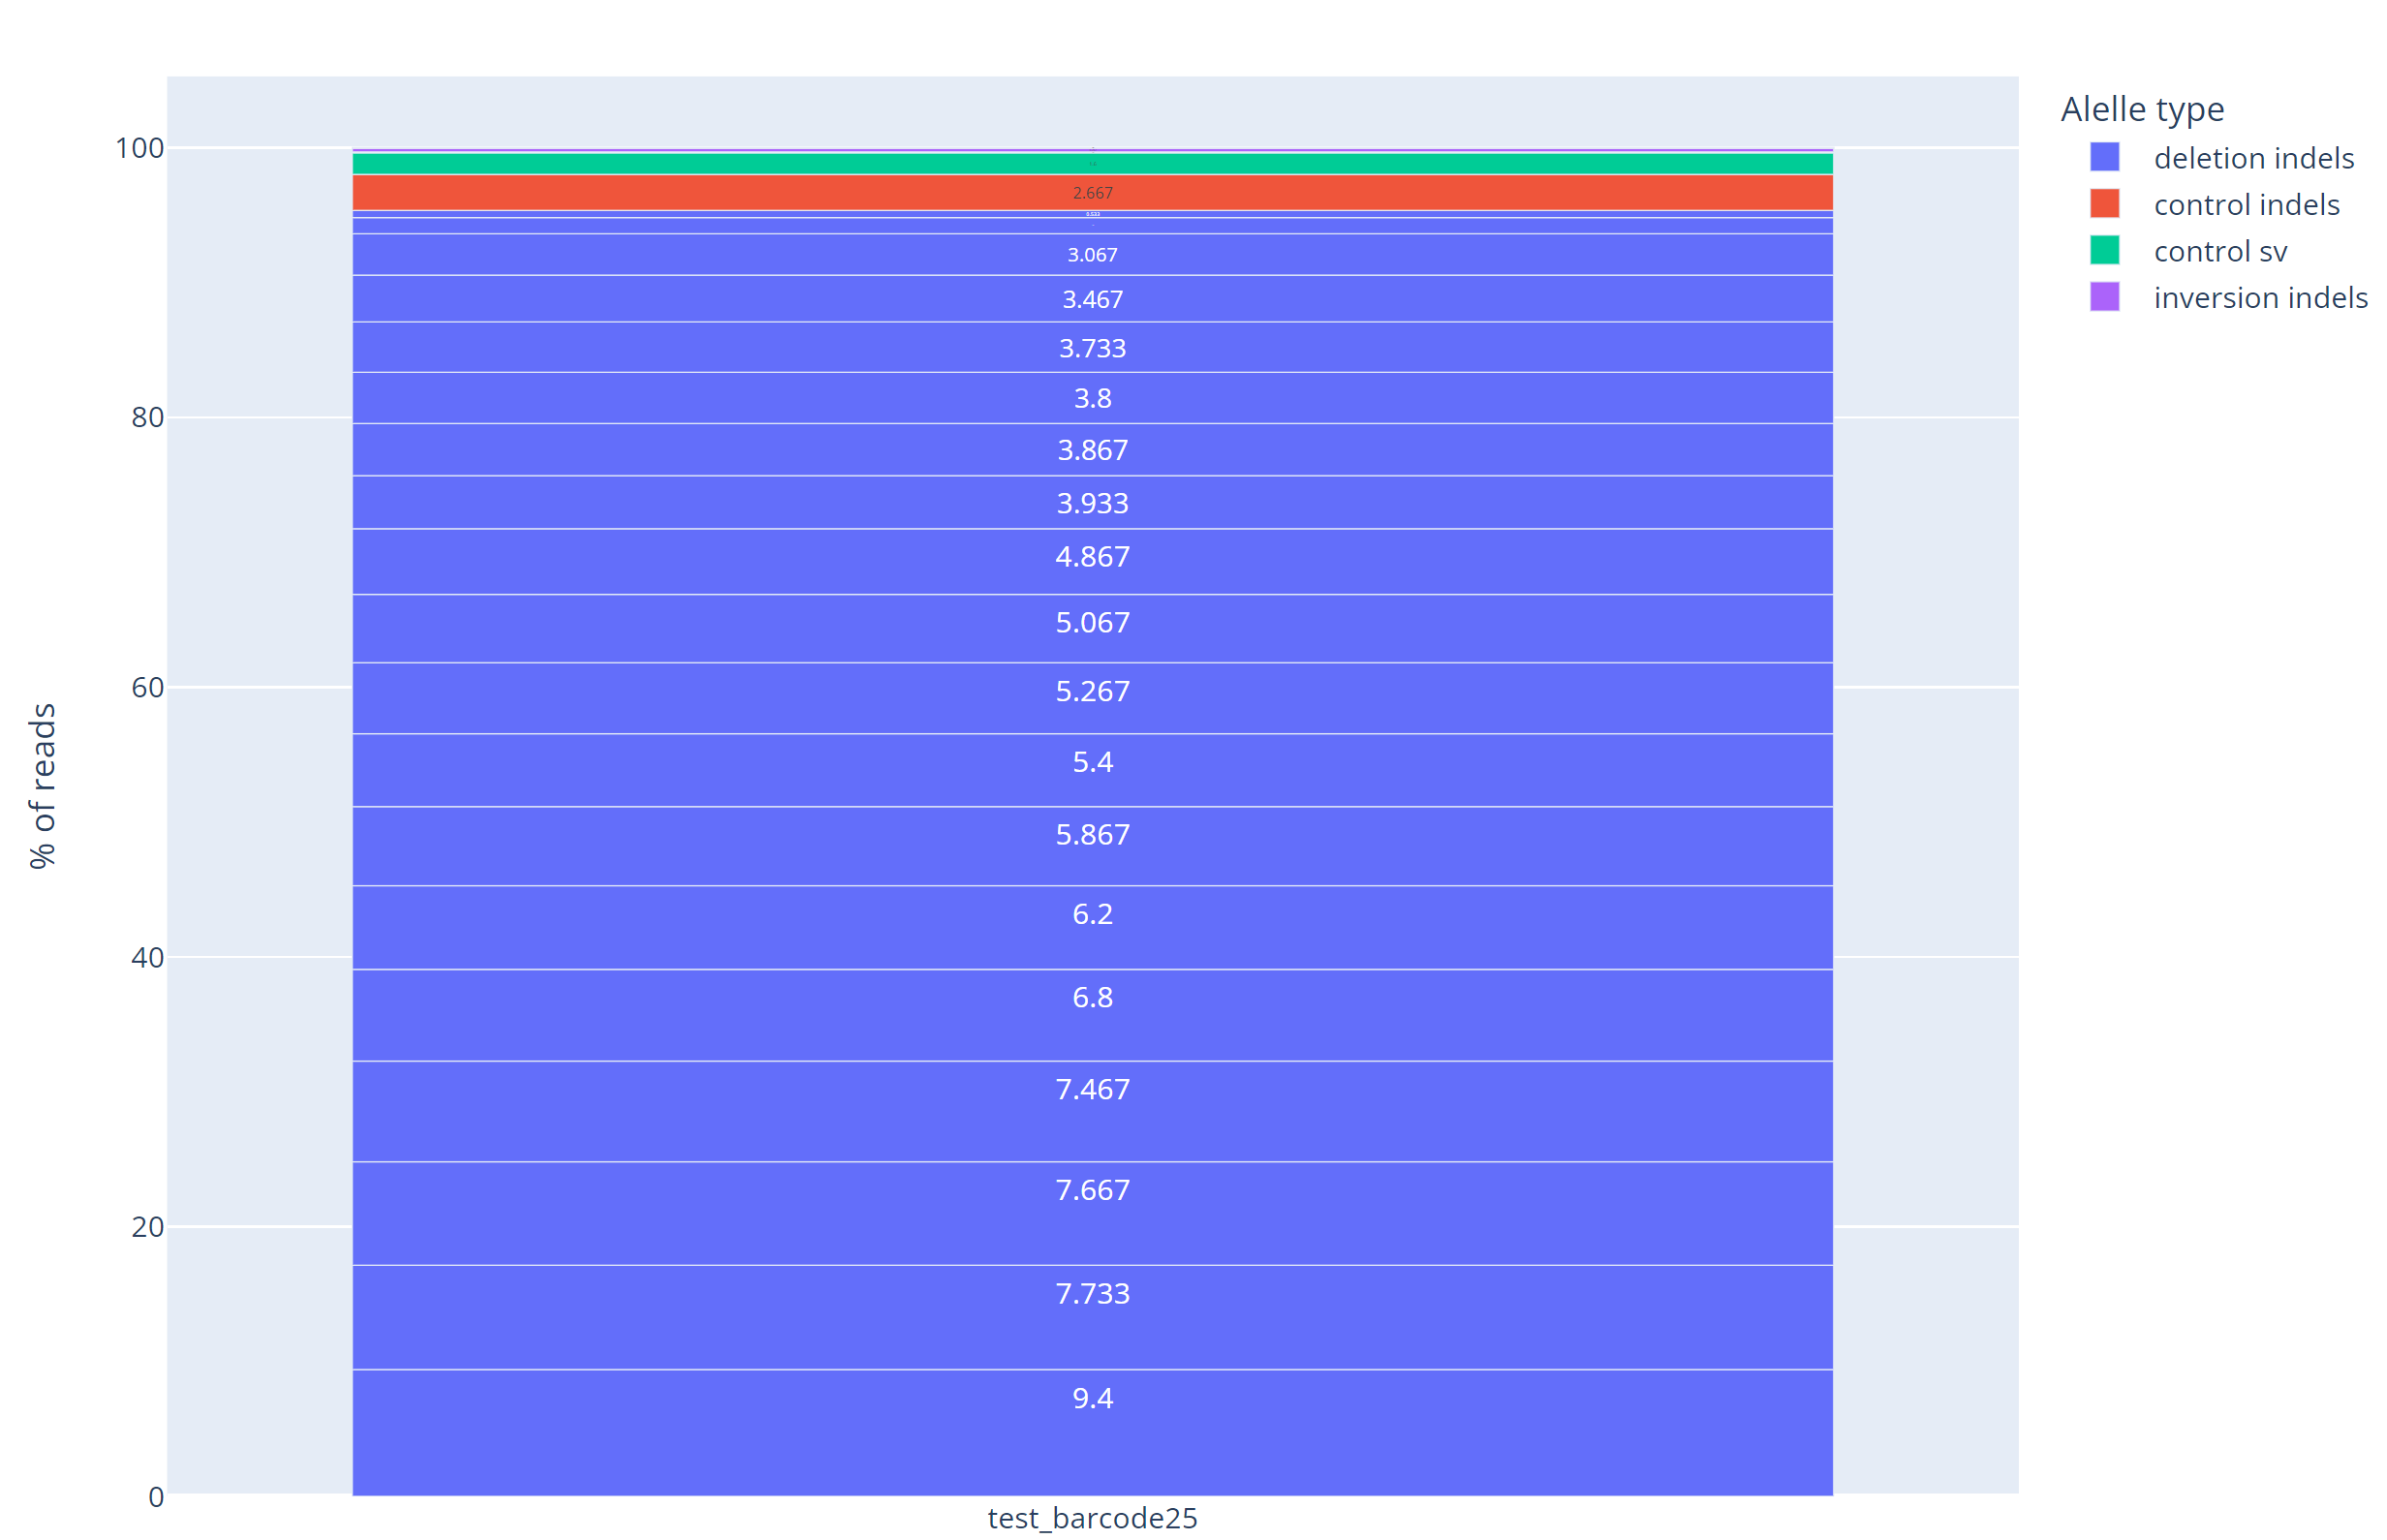

- 補正が一塩基単位でなされているみたいです

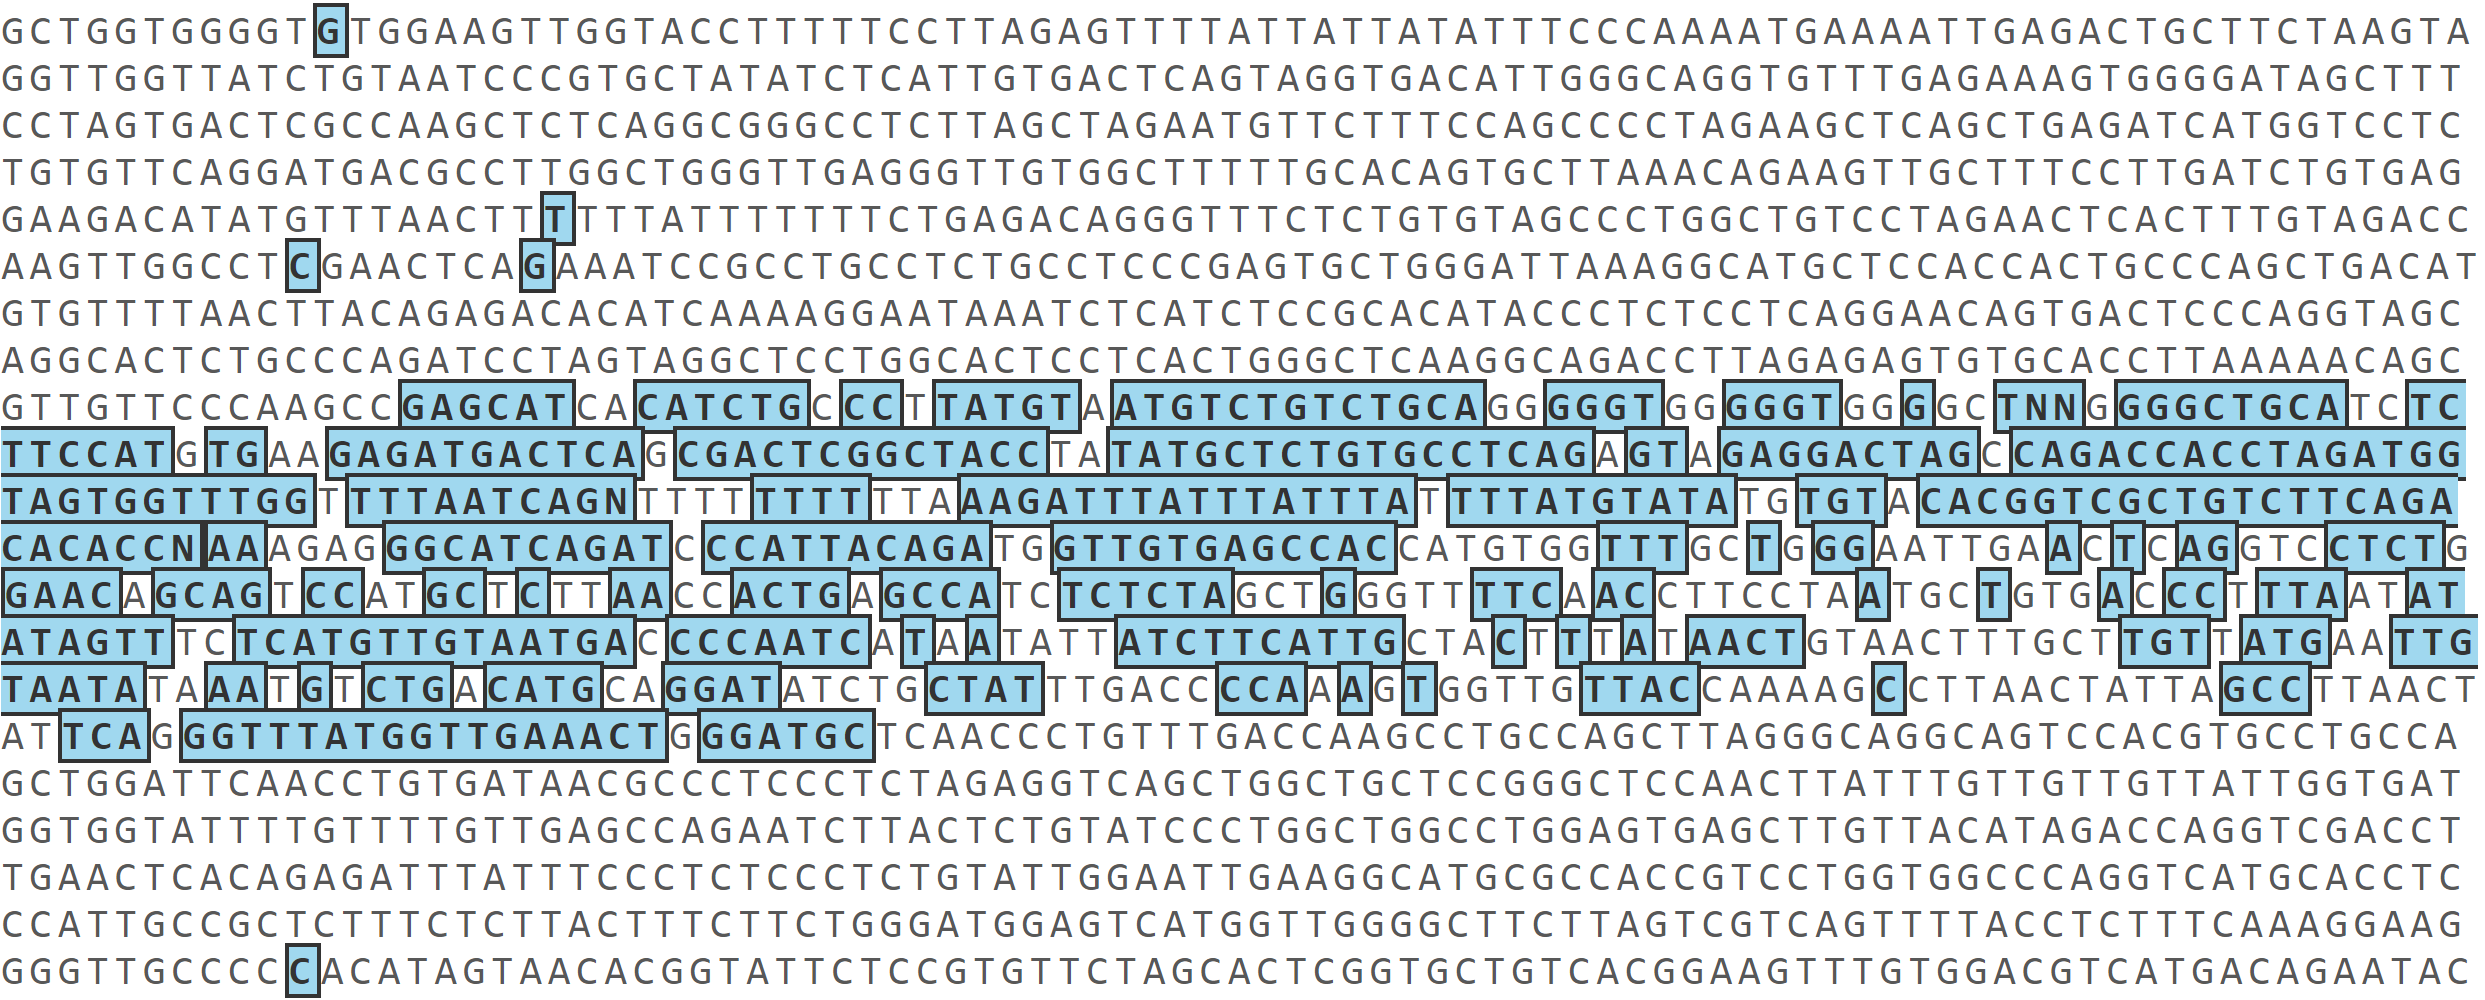

- いったん`correct_sequence_error`をもとに戻してみます

In [75]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m22.043s
user	5m21.843s
sys	1m2.433s


- うーん、`correct_sequence_error`を戻すと、前よりは良い感じですが、`call_midsv`で`map-ont`と`splice`を選ぶのに比べたら悪いです…
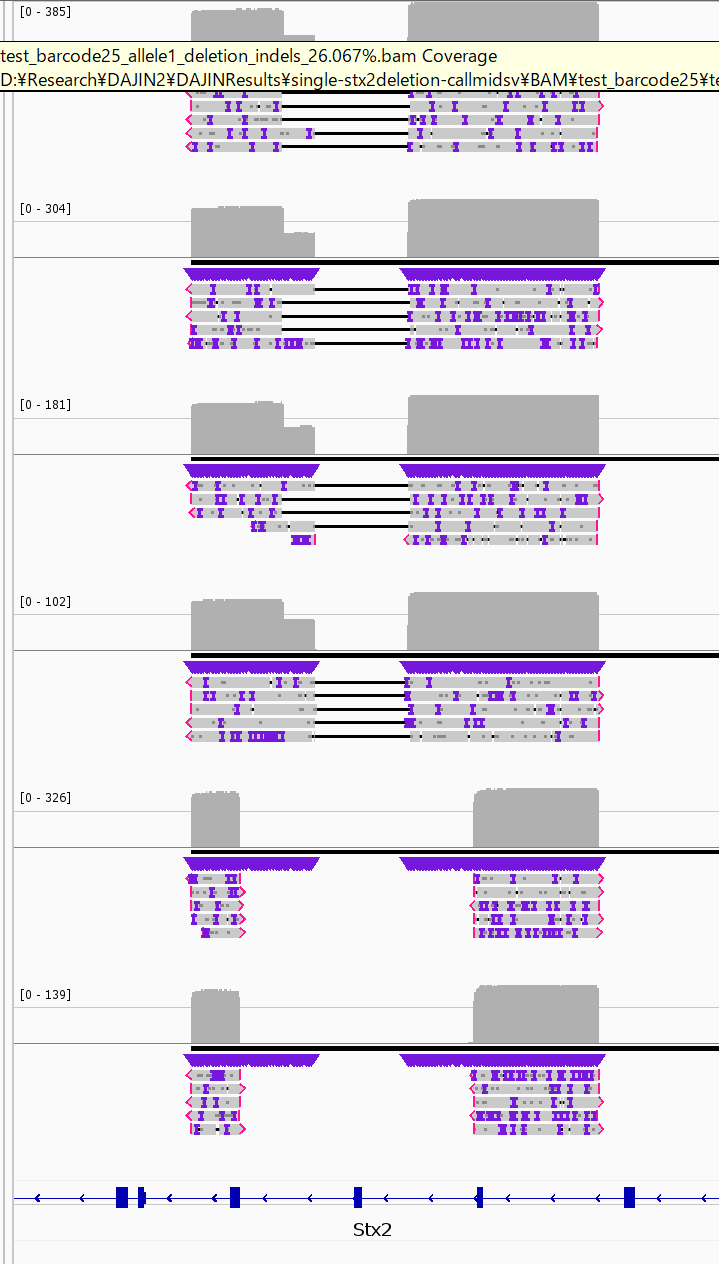

- 正直なんでこうなるのかよくわかっていません
    - 小規模、中規模欠失が同じクラスタになっている
    - 大規模欠失も2つのクラスタに分かれている

In [76]:
largedel1= "3467b1b6-d6e8-42af-9830-6f2e258503e6"
largedel2 = "1a075c28-d46e-44ca-bbed-5f9e6a2f0570"

In [79]:
print(qname_of_map_ont & {largedel1})
print(qname_of_map_ont & {largedel2})

set()
set()


In [80]:
allele="deletion"
midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

In [82]:
for samp in midsv_sample:
    if samp["QNAME"] in [largedel1, largedel2]:
        print(samp["QNAME"], samp["CSSPLIT"])

1a075c28-d46e-44ca-bbed-5f9e6a2f0570 =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,

↑ 両方とも、補正がめちゃくちゃです。大型欠失が反映されていない…

In [83]:
# いったん補正前にリセットします
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

In [84]:
allele="deletion"
midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
for samp in midsv_sample:
    if samp["QNAME"] in [largedel1, largedel2]:
        print(samp["QNAME"], samp["CSSPLIT"])

1a075c28-d46e-44ca-bbed-5f9e6a2f0570 =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,*AG,*AC,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,+G|=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,-G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,*TC,=A,=A,=C,+A|+G|=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,*CT,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,-G,=G,=A

↑ `call_midsv`は問題なさそうです

In [85]:
# ちょっとずつ進めます…
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
allele="deletion"
midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
for samp in midsv_sample:
    if samp["QNAME"] in [largedel1, largedel2]:
        print(samp["QNAME"], samp["CSSPLIT"])

1a075c28-d46e-44ca-bbed-5f9e6a2f0570 =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,*AG,*AC,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,+G|=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,-G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,*TC,=A,=A,=C,+A|+G|=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,*CT,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,-G,=G,=A

↑ `replace_NtoD`も問題なさそうです

In [86]:
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
allele="deletion"
midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
for samp in midsv_sample:
    if samp["QNAME"] in [largedel1, largedel2]:
        print(samp["QNAME"], samp["CSSPLIT"])

1a075c28-d46e-44ca-bbed-5f9e6a2f0570 =G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,+G|=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,-G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,*TC,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,*CT,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=

↑ `correct_sequence_error`が欠失をマッチに置換している様子です…なぜ…

In [87]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.ensemble import IsolationForest


# def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
#     count = {"ins": [1] * len(cssplits[0]),
#             "del": [1] * len(cssplits[0]),
#             "sub": [1] * len(cssplits[0])}
#     transposed_cssplits = [list(t) for t in zip(*cssplits)]
#     for i, transposed_cssplit in enumerate(transposed_cssplits):
#         for cs in transposed_cssplit:
#             if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
#                 continue
#             if cs.startswith("+"):
#                 count["ins"][i] += len(cs.split("|"))
#             elif cs.startswith("-"):
#                 count["del"][i] += 1
#             elif cs.startswith("*"):
#                 count["sub"][i] += 1
#     return count

# def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
#     count_indels_removed = dict()
#     threshold = coverage * 0.01
#     for key, values in count_indels.items():
#         values_removed = [v if v >= threshold else 1 for v in values]
#         count_indels_removed.update({key: values_removed})
#     return count_indels_removed


# def _extract_anomaly_loci(count_indels: dict[str, list[int | float]]) -> dict[str, set[int]]:
#     anomaly_loci = dict()
#     for key, values in count_indels.items():
#         clf = IsolationForest(random_state=0)
#         pred = clf.fit_predict(np.array(values).reshape(-1, 1))
#         loci = {i for i, p in enumerate(pred) if p == -1}
#         anomaly_loci.update({key: loci})
#     return anomaly_loci

# # def _score_anomaly(count_sample: list[int | float]) -> list[float]:
# #     x = np.array(count_sample)
# #     average = np.mean(x)
# #     sigma = np.std(x)
# #     score = np.square((x - average) / sigma)
# #     return score.tolist()


# # def _extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> set[int]:
# #     anomaly_loci = set()
# #     thres = chi2.ppf(q=threshold, df=1)
# #     for i, s in enumerate(score):
# #         if s > thres:
# #             anomaly_loci.add(i)
# #     return anomaly_loci


# def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
#     results = defaultdict(list)
#     center = kmer // 2
#     for mut, value in indels.items():
#         for i in range(len(value)):
#             if center <= i <= len(value) - center:
#                 start = i - center
#                 if kmer % 2 == 0:
#                     end = i + center
#                 else:
#                     end = i + center + 1
#                 results[mut].append(value[start : end])
#             else:
#                 results[mut].append([0]*kmer)
#     return results


# def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
#     results = defaultdict(list)
#     for mut, value in indels_sample.items():
#         for i, val in enumerate(value):
#             dist = distance.euclidean(val, indels_control[mut][i])
#             results[mut].append(dist)
#     return results

# def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
#     indels_sample = _count_indels(cssplits_sample)
#     indels_control = _count_indels(cssplits_control)
#     indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
#     indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
#     # anomaly at single locus
#     mutation_locus_single = {}
#     loci_sample = _extract_anomaly_loci(indels_sample)
#     loci_control = _extract_anomaly_loci(indels_control)
#     for key in ["ins", "del", "sub"]:
#         mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
#     # Difference of anomaly within kmers
#     x = _split_kmer(indels_sample, kmer = 10)
#     y = _split_kmer(indels_control, kmer = 10)
#     dists = _calc_distance(x, y)
#     loci_sample = _extract_anomaly_loci(dists)
#     mutation_locus_kmer = {}
#     for key in ["ins", "del", "sub"]:
#         # score_sample = _score_anomaly(dists[key])
#         mutation_locus_kmer.update({key: loci_sample[key]})
#     # Output
#     results = {}
#     for key in ["ins", "del", "sub"]:
#         results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
#     return results

# ###########################################################
# # postprocesss
# ###########################################################


# def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
#     results = []
#     for cssplits in cssplits_sample:
#         cssplits_replaced = []
#         for i, cs in enumerate(cssplits):
#             if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
#                 cssplits_replaced.append(cs)
#                 continue
#             if cs.startswith("+"):
#                 tag = "ins"
#             elif cs.startswith("-"):
#                 tag = "del"
#             else:
#                 tag = "sub"
#             if i in mutation_loci[tag]:
#                 cssplits_replaced.append(cs)
#             else:
#                 cssplits_replaced.append("@")
#         results.append(cssplits_replaced)
#     return results


# def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
#     random.seed(1)
#     cssplits_replaced = cssplits.copy()
#     sequence_length = len(sequence)
#     for i in range(1, sequence_length - 1):
#         cssplits_atmark = defaultdict(str)
#         cssplits_sampling_key = defaultdict(list)
#         cssplits_sampling_all = []
#         flag_all_atmark = True
#         for idx, cssplit in enumerate(cssplits):
#             key = ",".join([cssplit[i - 1], cssplit[i + 1]])
#             if cssplit[i] == "@":
#                 cssplits_atmark[idx] = key
#             else:
#                 cssplits_sampling_key[key].append(cssplit[i])
#                 cssplits_sampling_all.append(cssplit[i])
#                 flag_all_atmark = False
#         for idx, key in cssplits_atmark.items():
#             if flag_all_atmark:
#                 cssplits_replaced[idx][i] = "N"
#             elif cssplits_sampling_key[key]:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
#             else:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
#     for cs in cssplits_replaced:
#         if cs[0] == "@":
#             cs[0] = "N"
#         if cs[-1] == "@":
#             cs[-1] = "N"
#     return cssplits_replaced

# ###############################################################################
# # main
# ###############################################################################


# def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
#     for allele, sequence in FASTA_ALLELES.items():
#         midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
#         midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
#         cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
#         cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
#         # Extract mutation loci
#         mutation_loci = _extract(cssplits_sample, cssplits_control)
#         # Correct sequence errors
#         cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
#         cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
#         cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
#         cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
#         # Replace CSSPLIT
#         cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
#         cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
#         for i, cssplits in enumerate(cssplits_sample_corrected):
#             midsv_sample[i]["CSSPLIT"] = cssplits
#         for i, cssplits in enumerate(cssplits_control_corrected):
#             midsv_control[i]["CSSPLIT"] = cssplits
#         midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
#         midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))

###############################################################################

def _set_indexes(sequence: str):
    sequence_length = len(sequence)
    num_subset = sequence_length % 5
    left_idx = 0
    right_idx = sequence_length
    if num_subset == 1:
        left_idx += 1
    elif num_subset == 2:
        left_idx += 1
        right_idx -= 1
    elif num_subset == 3:
        left_idx += 2
        right_idx -= 1
    elif num_subset == 4:
        left_idx += 2
        right_idx -= 2
    return left_idx, right_idx


def _count_5mer_indels(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
    transposed = [list(t) for t in zip(*cssplits)]
    count_5mer = []
    for i in range(left_idx, right_idx, 5):
        count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
        cssplits_5mer = transposed[i : i + 5]
        for j, cs in enumerate(cssplits_5mer):
            counter = Counter(cs)
            for key, cnt in counter.items():
                if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
                    continue
                if key.startswith("+"):
                    count["ins"][j] += cnt
                elif key.startswith("-"):
                    count["del"][j] += cnt
                elif key.startswith("*"):
                    count["sub"][j] += cnt
        count_5mer.append(count)
    return count_5mer


def _remove_minor_indels(cssplits: list[list[str]], count_5mer: list[dict]) -> list[dict]:
    coverage = len(cssplits)
    count_5mer_filtered = []
    for count in count_5mer:
        dict_mutation = defaultdict(list)
        for mutation in ["ins", "del", "sub"]:
            if all(True if c < coverage * 0.01 else False for c in count[mutation]):
                dict_mutation[mutation] = [1] * 5
            else:
                dict_mutation[mutation] = count[mutation]
        count_5mer_filtered.append(dict_mutation)
    return count_5mer_filtered


def _extract_sequence_errors(count_5mer_sample, count_5mer_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    dists = defaultdict(list)
    # Calculate Jensen-Shannon distance
    for samp, cont in zip(count_5mer_sample, count_5mer_control):
        for mutation in ["ins", "del", "sub"]:
            s = samp[mutation]
            c = cont[mutation]
            dists[mutation].append(distance.jensenshannon(s, c))
    # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
    dists_all = np.array(list(dists.values())).flatten()
    avg = np.average(dists_all[~np.isnan(dists_all)])
    var = np.var(dists_all[~np.isnan(dists_all)])
    threshold = 0.05
    for mutation in ["ins", "del", "sub"]:
        dists_subset = dists[mutation]
        scores = [(xi - avg) ** 2 / var for xi in dists_subset]
        thres = stats.chi2.interval(1 - threshold, 1)[1]
        for i, score in enumerate(scores):
            # 'nan' means the two distributions have too different, so it could be a real mutation
            if np.isnan(score):
                continue
            if score < thres:
                sequence_errors[i].add(mutation)
    return sequence_errors


def _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
    cssplits_replaced = []
    for samp in cssplits_sample:
        samp_replaced = samp.copy()
        for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
            samp_5mer = samp[idx_5mer : idx_5mer + 5]
            error = sequence_errors[idx_error]
            if "ins" in error:
                samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
            if "del" in error:
                samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
            if "sub" in error:
                samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
            samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
        cssplits_replaced.append(samp_replaced)
    return cssplits_replaced


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract sequence errors
        left_idx, right_idx = _set_indexes(sequence)
        count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
        count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
        count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
        count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
        sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
        # Correct sequence errors
        cssplits_sample_error_replaced = _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
        cssplits_control_error_replaced = _replace_errors_to_atmark(
            cssplits_control, sequence_errors, left_idx, right_idx
        )
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_error_replaced, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_error_replaced, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [109]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)

sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

In [110]:
allele="deletion"

midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract sequence errors
left_idx, right_idx = _set_indexes(sequence)
count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)


In [111]:
print(count_5mer_sample[500])
print(count_5mer_control[500])
print(sequence_errors[500])

defaultdict(<class 'list'>, {'ins': [6, 7, 10, 4, 15], 'del': [476, 429, 427, 434, 428], 'sub': [16, 55, 7, 17, 15]})
defaultdict(<class 'list'>, {'ins': [3, 11, 6, 9, 9], 'del': [105, 34, 30, 35, 34], 'sub': [14, 92, 7, 13, 19]})
{'sub', 'ins', 'del'}


↑ 500番目（1500塩基目）は明らかにcontrolに比べてdeletionが多いのに、なぜかシークエンスエラーに分類されています…

In [115]:
print(count_5mer_sample[100])
print(count_5mer_control[100])
print(sequence_errors[100])

defaultdict(<class 'list'>, {'ins': [15, 5, 53, 40, 7], 'del': [9, 22, 12, 117, 70], 'sub': [12, 50, 5, 31, 42]})
defaultdict(<class 'list'>, {'ins': [7, 3, 32, 22, 1], 'del': [11, 18, 13, 75, 41], 'sub': [2, 27, 6, 20, 24]})
set()


In [112]:
sequence_errors = [set() for _ in range(len(count_5mer_sample))]
dists = defaultdict(list)
# Calculate Jensen-Shannon distance
for samp, cont in zip(count_5mer_sample, count_5mer_control):
    for mutation in ["ins", "del", "sub"]:
        s = samp[mutation]
        c = cont[mutation]
        dists[mutation].append(distance.jensenshannon(s, c))
# Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
dists_all = np.array(list(dists.values())).flatten()


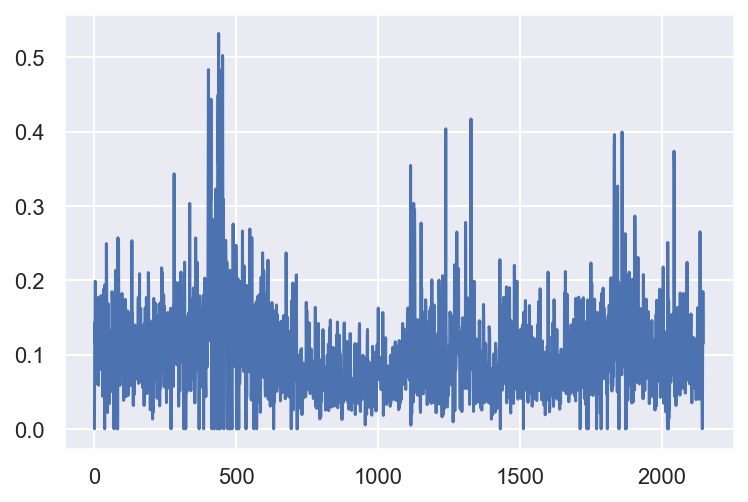

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.plot(dists_all)

- Janon-Shannon distanceがうまく機能していないようです…
- まえはある程度うまく行っていたのに…
    - replace_NtoDの場所を変えたのが原因でしょうか？
- いずれにしてもやっぱり`cal_midsv`のアルゴリズムを変更します

In [116]:
#call_midsv
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.ensemble import IsolationForest

def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(count_indels: dict[str, list[int | float]]) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in count_indels.items():
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci

# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci_hotelling(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    mutation_locus_single = {}
    loci_sample = _extract_anomaly_loci(indels_sample)
    loci_control = _extract_anomaly_loci(indels_control)
    for key in ["ins", "del", "sub"]:
        mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    loci_sample = _extract_anomaly_loci(dists)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        # score_sample = _score_anomaly(dists[key])
        mutation_locus_kmer.update({key: loci_sample[key]})
    # Output
    results = {}
    for key in ["ins", "del", "sub"]:
        results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return results

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))



In [128]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)

allele = "deletion"
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [132]:
# ちゃんと欠失があるかカウント
allele = "deletion"

midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
count = defaultdict(int)
for cssplits in cssplits_sample:
    count[cssplits[1500]] += 1

print(count)

defaultdict(<class 'int'>, {'=C': 913, '-C': 515, '+C|=C': 44, '*CA': 2, '+T|+G|*CT': 2, '*CG': 7, '+G|=C': 1, '+C|+T|+A|=C': 1, '+T|+G|+T|+G|+G|*CG': 1, '+G|*CT': 2, '+C|+C|=C': 2, '*CT': 6, 'N': 3, '+T|+A|=C': 1})


In [133]:
# Extract mutation loci
mutation_loci = _extract(cssplits_sample, cssplits_control)
print(len(mutation_loci["ins"]))
print(len(mutation_loci["del"]))
print(len(mutation_loci["sub"]))

50
449
44


In [134]:
1500 in mutation_loci["del"]

False

In [135]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# anomaly at single locus
mutation_locus_single = {}
loci_sample = _extract_anomaly_loci(indels_sample)
loci_control = _extract_anomaly_loci(indels_control)
for key in ["ins", "del", "sub"]:
    mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    # score_sample = _score_anomaly(dists[key])
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
results = {}
for key in ["ins", "del", "sub"]:
    results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})

In [139]:
print(indels_sample["del"][1500])
print(indels_control["del"][1500])
print(1500 in loci_sample["del"])

516
23
False


↑ 1500番目の欠失が正常と判定されている

In [158]:
def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, sample_values in indels_sample.items():
        values = sample_values + indels_control[key]
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))[:len(sample_values)]
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [161]:
loci_sample_after = _extract_anomaly_loci(indels_sample, indels_control)
print(loci_sample_after["del"])
print(len(indels_sample["del"]))

1450
{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 19, 20, 22, 23, 31, 34, 38, 42, 52, 54, 58, 64, 74, 75, 78, 79, 80, 81, 82, 83, 87, 100, 106, 108, 109, 117, 121, 130, 132, 143, 147, 150, 159, 160, 161, 162, 166, 167, 169, 170, 174, 176, 186, 188, 190, 191, 209, 213, 216, 218, 228, 229, 230, 241, 250, 260, 261, 266, 281, 282, 283, 286, 292, 300, 309, 314, 315, 316, 317, 318, 322, 327, 328, 338, 339, 346, 347, 349, 350, 351, 354, 359, 361, 362, 364, 365, 370, 371, 374, 375, 377, 391, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 421, 442, 444, 446, 447, 449, 450, 453, 468, 490, 492, 499, 501, 504, 506, 508, 513, 530, 536, 545, 548, 551, 552, 555, 564, 570, 578, 581, 582, 593, 598, 602, 608, 615, 618, 619, 620, 631, 633, 634, 640, 654, 659, 671, 672, 673, 679, 680, 684, 696, 700, 701, 705, 706, 708, 709, 715, 730, 737, 739, 751, 763, 781, 785, 786, 790, 791, 794, 804, 810, 812, 814, 822, 825, 828, 830, 837, 840, 844, 847, 850, 859, 860, 870, 872, 873, 874, 879, 880, 884, 886, 88

In [154]:
key = "del"
sample_values = indels_sample[key]
values = sample_values + indels_control[key]
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))[:len(sample_values)]

-1


In [152]:
print(pred[:9])
print(indels_sample[key][:9])
print(indels_control[key][:9])

[-1 -1 -1 -1 -1 -1  1 -1 -1]
[1, 1, 1, 1, 1, 1, 46, 1, 1]
[1, 1, 1, 1, 1, 1, 31, 1, 1]


In [172]:
def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, sample_values in indels_sample.items():
        values = sample_values + indels_control[key]
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))[:len(sample_values)]
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして-1が正常か異常かを判定する
        if Counter(pred[:9]).most_common()[0][0] == 1:
            abnormal = -1
        else:
            abnormal = 1
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [173]:
loci_sample_after = _extract_anomaly_loci(indels_sample, indels_control)
print(1500 in loci_sample_after["del"])
print(len(indels_sample["del"]))

True
3582


In [176]:
def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in indels_sample.items():
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))[:len(sample_values)]
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして-1が正常か異常かを判定する
        if Counter(pred[:9]).most_common()[0][0] == 1:
            abnormal = -1
        else:
            abnormal = 1
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [178]:
loci_sample_after = _extract_anomaly_loci(indels_sample)
print(1500 in loci_sample_after["del"])
print(len(indels_sample["del"]))

True
3582


1450
{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 19, 20, 22, 23, 31, 34, 38, 42, 52, 54, 58, 64, 74, 75, 78, 79, 80, 81, 82, 83, 87, 100, 106, 108, 109, 117, 121, 130, 132, 143, 147, 150, 159, 160, 161, 162, 166, 167, 169, 170, 174, 176, 186, 188, 190, 191, 209, 213, 216, 218, 228, 229, 230, 241, 250, 260, 261, 266, 281, 282, 283, 286, 292, 300, 309, 314, 315, 316, 317, 318, 322, 327, 328, 338, 339, 346, 347, 349, 350, 351, 354, 359, 361, 362, 364, 365, 370, 371, 374, 375, 377, 391, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 421, 442, 444, 446, 447, 449, 450, 453, 468, 490, 492, 499, 501, 504, 506, 508, 513, 530, 536, 545, 548, 551, 552, 555, 564, 570, 578, 581, 582, 593, 598, 602, 608, 615, 618, 619, 620, 631, 633, 634, 640, 654, 659, 671, 672, 673, 679, 680, 684, 696, 700, 701, 705, 706, 708, 709, 715, 730, 737, 739, 751, 763, 781, 785, 786, 790, 791, 794, 804, 810, 812, 814, 822, 825, 828, 830, 837, 840, 844, 847, 850, 859, 860, 870, 872, 873, 874, 879, 880, 884, 886, 88

- `correct_sequence_error`の`_extract_anomaly`を更新しました
  - 配列の全体にまたがる変異（大型欠失がある場合など）で、変異のほうが正常に判断されるというバグがありました
  - 最初の9塩基はまず間違いなく正常なので、この値（1 or -1）を正常と判定するようにしました

In [180]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

rm: cannot remove 'DAJINResults/.tempdir/single-stx2deletion-callmidsv/midsv': Directory not empty
Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 10, in single_execute
    core_execute.execute_control(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 77, in execute_control
    preprocess.call_midsv(TEMPDIR, CONTROL_NAME, allele)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/call_midsv.py", line 75, in call_midsv
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
  File "/home/kuno/miniconda/lib/python3.10/site-packages/midsv/io.py", line 12, in read_sam
    sam = Path(path_of_sam).read_text().strip().split("\n")
  File "/home/ku

Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m37.546s
user	5m59.707s
sys	1m56.695s


- 笑ってしまうほどカオスの様相を呈してきました
  - なぜかinversion indelsが出てきました
  - いちおう、大きく分けて3アレルになっており、分類もいい感じになっています

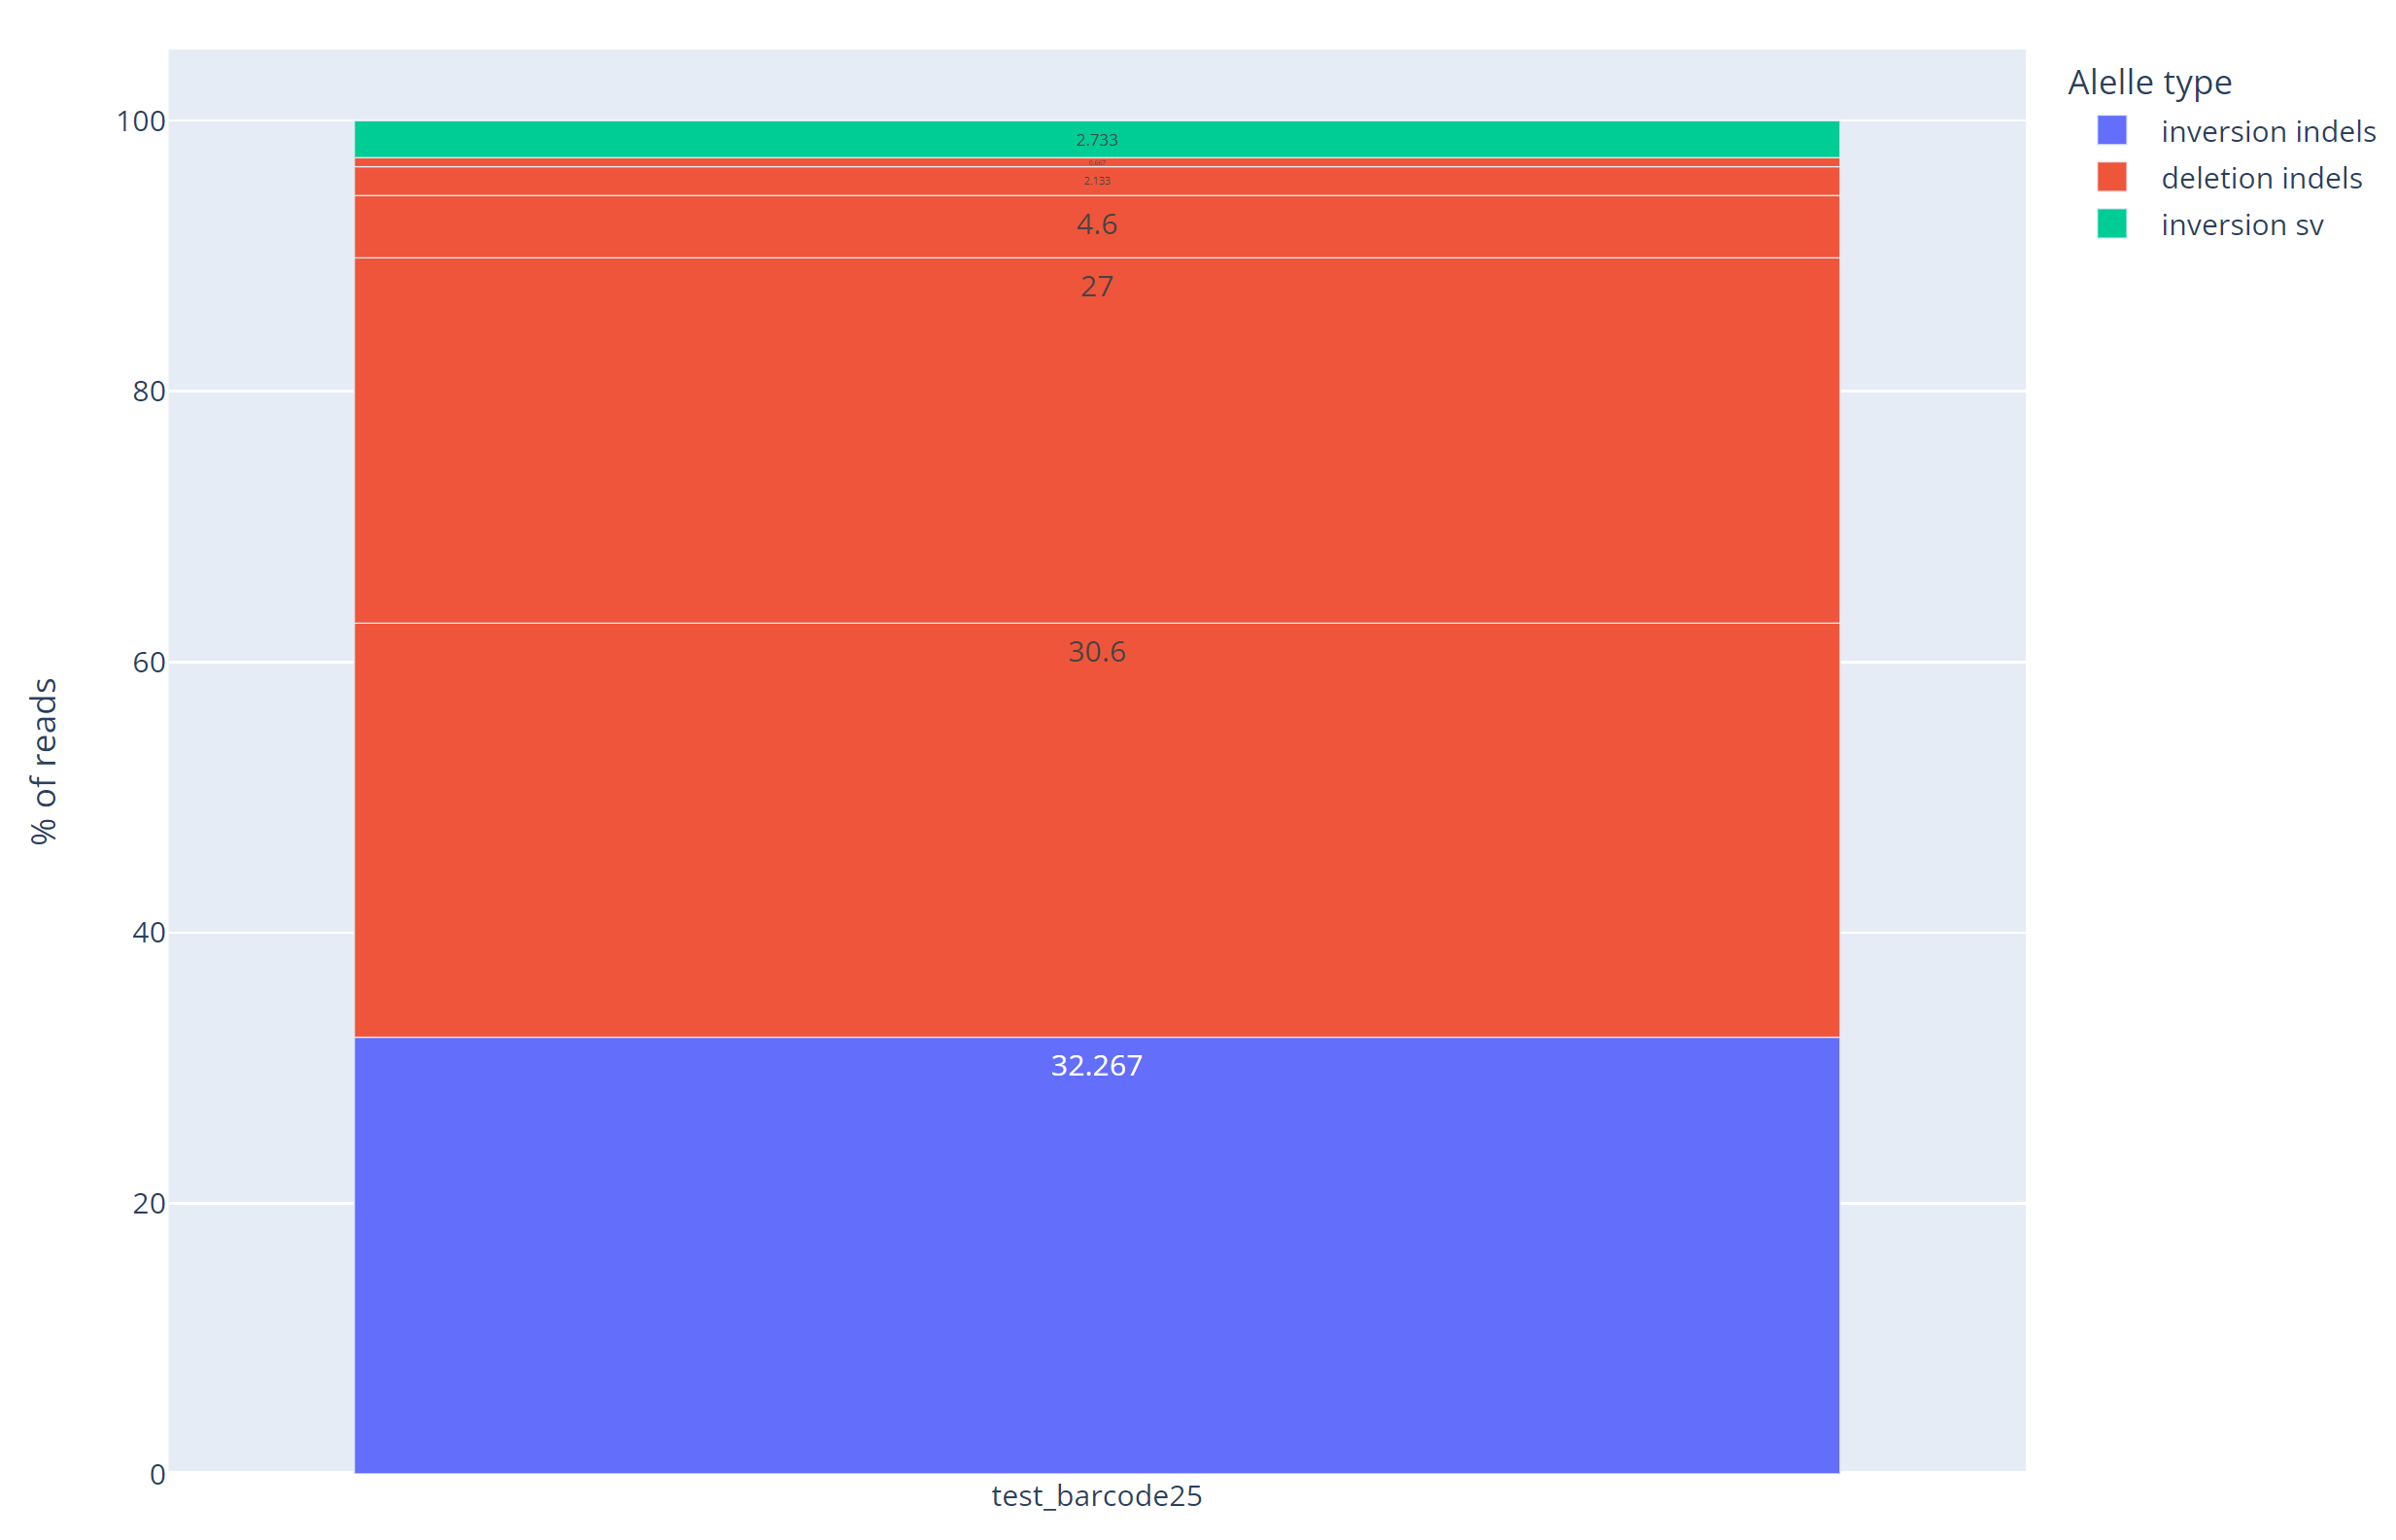

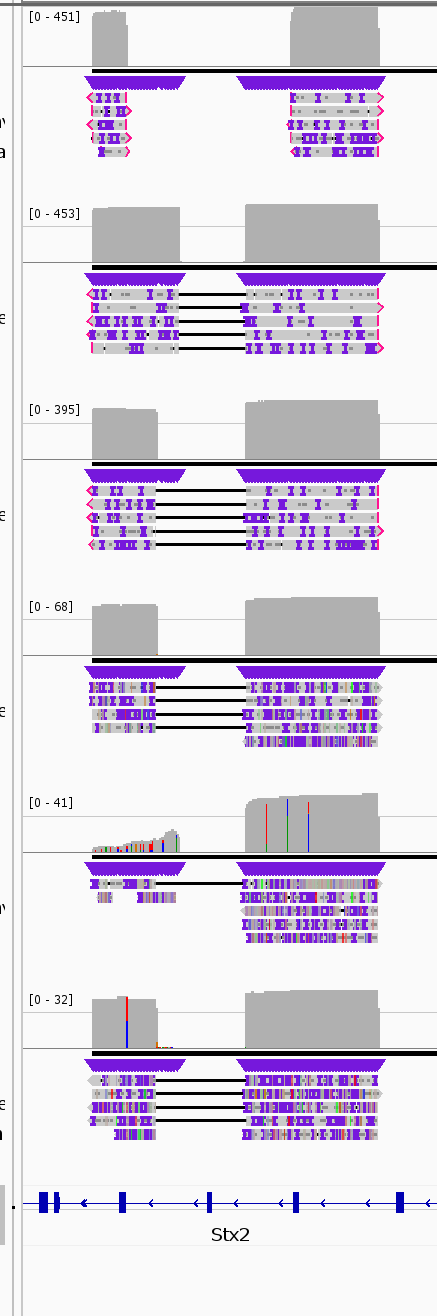

- しかしながら、補正はぜんぜんうまく行っていない様子です
  - 欠失があるはずなのになくなっています

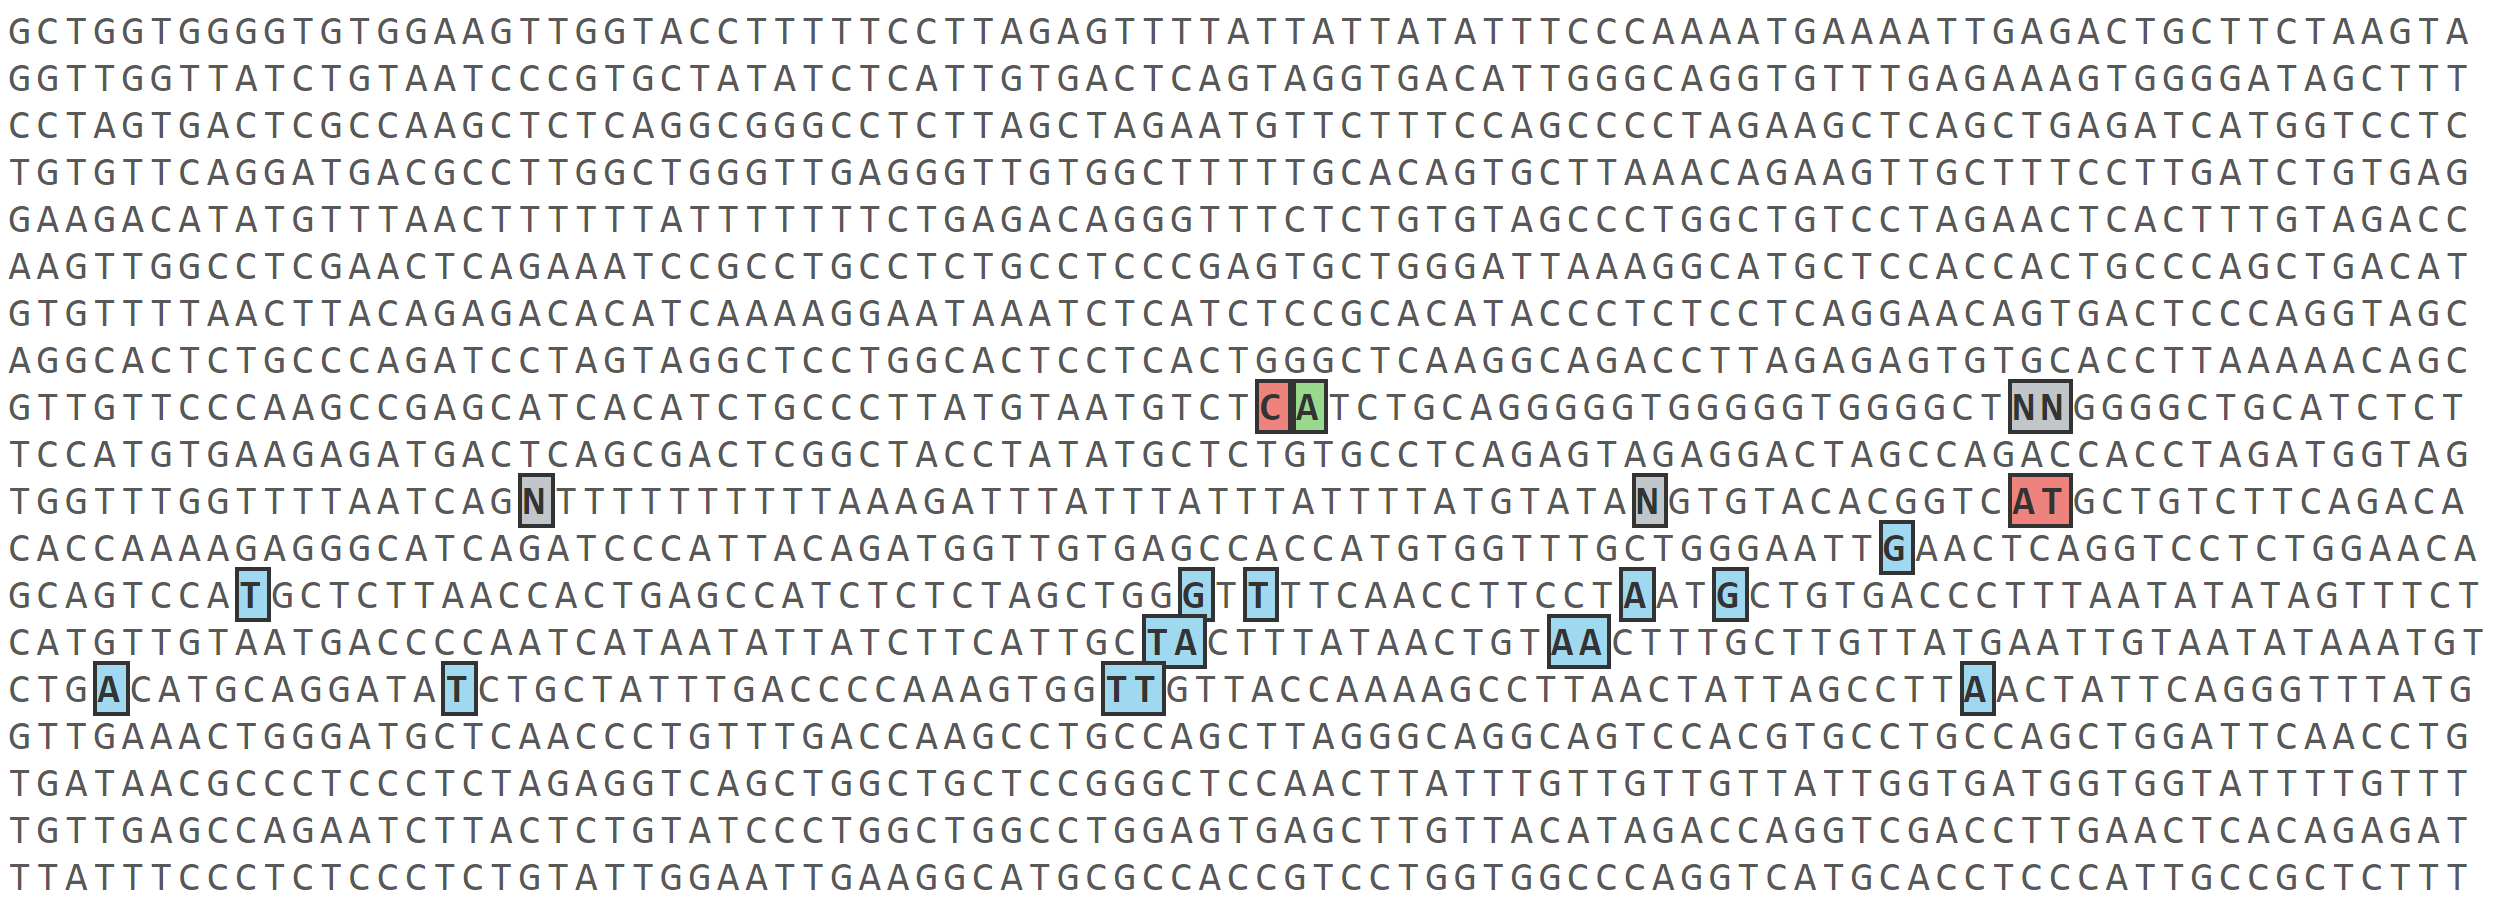

### ✡ いったん補正前にリセットします

In [200]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)

allele = "deletion"
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [201]:
def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in indels_sample.items():
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして-1が正常か異常かを判定する
        if Counter(pred[:9]).most_common()[0][0] == 1:
            abnormal = -1
        else:
            abnormal = 1
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# anomaly at single locus
mutation_locus_single = _extract_anomaly_loci(indels_sample)
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    # score_sample = _score_anomaly(dists[key])
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
mutation_loci = {}
for key in ["ins", "del", "sub"]:
    mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [202]:
print(2500 in mutation_loci["del"])
print(len(mutation_loci["del"]))

False
2123


In [203]:
cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)

In [204]:
count = defaultdict(int)
for samp in cssplits_sample_atmark_replaced:
    count[samp[2500]] += 1

print(count)

defaultdict(<class 'int'>, {'=A': 1481, 'N': 16, '+A|=A': 1, '+T|=A': 1, '=a': 1})


In [205]:
count = defaultdict(int)
for samp in cssplits_sample:
    count[samp[2500]] += 1

print(count)

defaultdict(<class 'int'>, {'=A': 424, '-A': 1050, 'N': 16, '*AG': 5, '*AC': 1, '+A|=A': 1, '+T|=A': 1, '=a': 1, '*AT': 1})


In [206]:
print(indels_sample["del"][2500])
print(indels_control["del"][2500])
print(2500 in mutation_loci["del"])

1051
119
False


↑ 2500番目の塩基が正常と判定されています…これは変異なはずです。

In [208]:
print(2500 in mutation_locus_single["del"])
print(2500 in mutation_locus_kmer["del"])

False
False


In [212]:
values = indels_sample["del"]
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
# はじめの9塩基はまず正常と判定されるはずなので、これをもとにして-1が正常か異常かを判定する
if Counter(pred[:9]).most_common()[0][0] == 1:
    abnormal = -1
else:
    abnormal = 1
loci = {i for i, p in enumerate(pred) if p == abnormal}


In [227]:
print(pred[:9])
print(pred[2500:2510])
print(pred[100:110])

[-1 -1 -1 -1 -1 -1  1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1  1 -1  1  1  1 -1  1 -1 -1]


In [228]:
print(values[:9])
print(values[2500: 2510])
print(values[100:110])

[1, 1, 1, 1, 1, 1, 46, 1, 1]
[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]
[138, 21, 15, 22, 34, 39, 100, 26, 1, 1]


In [218]:
count = defaultdict(int)
for samp in cssplits_sample:
    count[samp[0]] += 1

print(count)
count = defaultdict(int)
for samp in cssplits_sample:
    count[samp[2500]] += 1

print(count)

defaultdict(<class 'int'>, {'N': 445, '=G': 1055})
defaultdict(<class 'int'>, {'=A': 424, '-A': 1050, 'N': 16, '*AG': 5, '*AC': 1, '+A|=A': 1, '+T|=A': 1, '=a': 1, '*AT': 1})


- novelty detectionを使う？

In [268]:
key = "del"
array_control = np.array(indels_control[key]).reshape(-1, 1)
array_sample = np.array(indels_sample[key]).reshape(-1, 1)

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(novelty=True)
clf.fit(np.log(array_control))
y_pred_test = clf.predict(np.log(array_sample))

In [269]:
print(indels_control[key][20:30])
print(indels_sample[key][20:30])
print(y_pred_test[20:30])
print(indels_control[key][1500:1510])
print(indels_sample[key][1500:1510])
print(y_pred_test[1500:1510])
print(indels_control[key][2500: 2510])
print(indels_sample[key][2500: 2510])
print(y_pred_test[2500:2510])

[1, 28, 1, 1, 26, 42, 31, 37, 25, 53]
[1, 31, 1, 1, 31, 51, 30, 44, 24, 78]
[1 1 1 1 1 1 1 1 1 1]
[23, 26, 44, 36, 34, 65, 26, 21, 32, 25]
[516, 511, 516, 512, 512, 554, 504, 504, 530, 513]
[1 1 1 1 1 1 1 1 1 1]
[119, 105, 34, 30, 35, 34, 39, 40, 41, 31]
[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [274]:
key = "del"
array_control = np.array(indels_control[key]).reshape(-1, 1)
array_sample = np.array(indels_sample[key]).reshape(-1, 1)

from sklearn.svm import OneClassSVM
clf = OneClassSVM()
clf.fit(array_control)
y_pred_test = clf.predict(array_sample)

In [275]:
print(indels_control[key][20:30])
print(indels_sample[key][20:30])
print(y_pred_test[20:30])
print("=======================")
print(indels_control[key][1500:1510])
print(indels_sample[key][1500:1510])
print(y_pred_test[1500:1510])
print("=======================")
print(indels_control[key][2500: 2510])
print(indels_sample[key][2500: 2510])
print(y_pred_test[2500:2510])

[1, 28, 1, 1, 26, 42, 31, 37, 25, 53]
[1, 31, 1, 1, 31, 51, 30, 44, 24, 78]
[-1  1 -1 -1  1 -1  1  1  1 -1]
[23, 26, 44, 36, 34, 65, 26, 21, 32, 25]
[516, 511, 516, 512, 512, 554, 504, 504, 530, 513]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[119, 105, 34, 30, 35, 34, 39, 40, 41, 31]
[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


- novelty detectionも筋が悪そうです
- 本当は、[20:30]は正常、[1500:1510]と[2500:2510]は異常と判定されてほしいのですが...

In [276]:
def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, sample_values in indels_sample.items():
        values = sample_values + indels_control[key]
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        pred_sample = pred[:len(sample_values)]
        pred_control = pred[len(sample_values):]
        # pred_controlの多くは正常なはずなので、これをもとにして-1が正常か異常かを判定する
        if Counter(pred_control).most_common()[0][0] == 1:
            abnormal = -1
        else:
            abnormal = 1
        loci = {i for i, p in enumerate(pred_sample) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

In [282]:
key = "del"
sample_values = indels_sample[key]
values = sample_values + indels_control[key]
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
pred_sample = pred[:len(sample_values)]
pred_control = pred[len(sample_values):]

In [283]:
print(indels_control[key][20:30])
print(indels_sample[key][20:30])
print(pred_sample[20:30])
print("=======================")
print(indels_control[key][1500:1510])
print(indels_sample[key][1500:1510])
print(pred_sample[1500:1510])
print("=======================")
print(indels_control[key][2500: 2510])
print(indels_sample[key][2500: 2510])
print(pred_sample[2500:2510])

[1, 28, 1, 1, 26, 42, 31, 37, 25, 53]
[1, 31, 1, 1, 31, 51, 30, 44, 24, 78]
[-1  1 -1 -1  1  1  1  1  1  1]
[23, 26, 44, 36, 34, 65, 26, 21, 32, 25]
[516, 511, 516, 512, 512, 554, 504, 504, 530, 513]
[ 1  1  1  1  1 -1 -1 -1  1  1]
[119, 105, 34, 30, 35, 34, 39, 40, 41, 31]
[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [284]:
from sklearn.mixture import GaussianMixture
key = "del"
sample_values = indels_sample[key]
clf = GaussianMixture(n_components = 2, random_state=0)
pred = clf.fit_predict(np.array(sample_values).reshape(-1, 1))

In [286]:
print(indels_control[key][20:30])
print(indels_sample[key][20:30])
print(pred[20:30])
print("=======================")
print(indels_control[key][1500:1510])
print(indels_sample[key][1500:1510])
print(pred[1500:1510])
print("=======================")
print(indels_control[key][2500: 2510])
print(indels_sample[key][2500: 2510])
print(pred[2500:2510])
print(Counter(pred))

[1, 28, 1, 1, 26, 42, 31, 37, 25, 53]
[1, 31, 1, 1, 31, 51, 30, 44, 24, 78]
[1 1 1 1 1 1 1 1 1 1]
[23, 26, 44, 36, 34, 65, 26, 21, 32, 25]
[516, 511, 516, 512, 512, 554, 504, 504, 530, 513]
[0 0 0 0 0 0 0 0 0 0]
[119, 105, 34, 30, 35, 34, 39, 40, 41, 31]
[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]
[0 0 0 0 0 0 0 0 0 0]
Counter({0: 1945, 1: 1637})


- おお！混合ガウス分布モデルで2つの異なるガウス分布を仮定すると、{[20:30]}と{[1500:1510]と[2500:2510]}が分かれます。

In [289]:
print(pred[:100])
print("=======================")
print(pred[1500:1600])
print("=======================")
print(pred[2500:2600])
print("=======================")
print(pred[-100:])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [290]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in indels_sample.items():
        clf = GaussianMixture(n_components = 2, random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして-1が正常か異常かを判定する
        if Counter(pred[:9]).most_common()[0][0] == 1:
            abnormal = -1
        else:
            abnormal = 1
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci_hotelling(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    mutation_locus_single = _extract_anomaly_loci(indels_sample)
    # mutation_locus_single = {}
    # loci_sample = _extract_anomaly_loci(indels_sample)
    # loci_control = _extract_anomaly_loci(indels_control)
    # for key in ["ins", "del", "sub"]:
    #     mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    loci_sample = _extract_anomaly_loci(dists)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        # score_sample = _score_anomaly(dists[key])
        mutation_locus_kmer.update({key: loci_sample[key]})
    # Output
    mutation_loci = {}
    for key in ["ins", "del", "sub"]:
        mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))

In [291]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)

allele = "deletion"
sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
qname_of_single_read = _get_qname_of_single_read(sam_ont)
qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [292]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract(cssplits_sample, cssplits_control)

In [293]:
print(mutation_loci["del"])

set()


In [294]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Anomaly at single locus
mutation_locus_single = _extract_anomaly_loci(indels_sample)
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
mutation_loci = {}
for key in ["ins", "del", "sub"]:
    mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [296]:
print(mutation_locus_single["del"])
print(mutation_loci["del"])

set()
set()


In [298]:
print(indels_sample["del"][2500:2510])

[1051, 1046, 999, 997, 1004, 998, 1003, 999, 1000, 997]


In [333]:
values = indels_sample["del"]
clf = GaussianMixture(n_components = 2, random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
# はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
normal, abnormal = Counter(pred).keys()
if Counter(pred[:9]).most_common()[0][0] == abnormal:
    normal, abnormal = abnormal, normal
loci = {i for i, p in enumerate(pred) if p == abnormal}


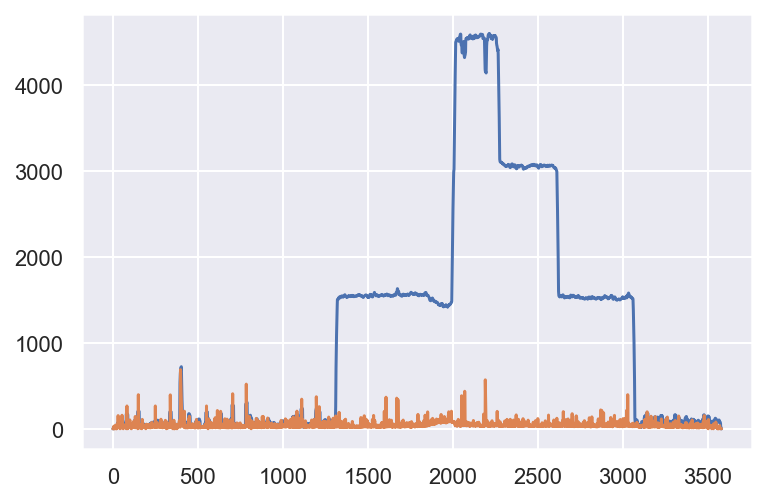

In [338]:
plt.plot(values)
plt.plot(indels_control["del"])

In [335]:
normal, abnormal = Counter(pred).keys()
print(label1, label2)
print(abnormal)
print(loci)
print(1500 in loci)
print(2500 in loci)

1 0
0
{31, 54, 58, 81, 82, 83, 100, 106, 117, 121, 132, 150, 250, 260, 261, 282, 283, 309, 314, 338, 339, 359, 391, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 421, 444, 446, 447, 449, 450, 490, 492, 504, 508, 548, 551, 552, 555, 564, 578, 598, 602, 608, 615, 618, 619, 620, 634, 659, 671, 672, 684, 696, 700, 705, 706, 785, 786, 790, 791, 804, 810, 812, 825, 844, 847, 850, 859, 860, 879, 880, 884, 891, 911, 916, 920, 952, 990, 1015, 1022, 1023, 1029, 1042, 1050, 1053, 1061, 1062, 1064, 1083, 1095, 1097, 1109, 1110, 1111, 1112, 1116, 1132, 1133, 1169, 1183, 1184, 1197, 1198, 1199, 1200, 1201, 1202, 1214, 1226, 1239, 1248, 1251, 1268, 1270, 1281, 1287, 1296, 1299, 1301, 1311, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 

In [309]:
def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in indels_sample.items():
        clf = GaussianMixture(n_components = 2, random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [310]:
mutation_loci = _extract(cssplits_sample, cssplits_control)

In [313]:
1500 in mutation_loci["del"]

False

In [315]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Anomaly at single locus
mutation_locus_single = _extract_anomaly_loci(indels_sample)
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
mutation_loci = {}
for key in ["ins", "del", "sub"]:
    mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [322]:
1500 in mutation_locus_kmer["del"]
# なんでFalseなのよ！

False

In [323]:
print(dists["del"][:10])
print(dists["del"][1500:1510])
print(dists["del"][2500:2510])


[0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 15.0, 15.0, 17.4928556845359, 17.4928556845359]
[1533.2318807016766, 1533.55045564207, 1528.471458680207, 1527.8380149741006, 1531.697424428206, 1530.7383839180359, 1530.7383839180359, 1531.3732399385854, 1539.262485737894, 1543.3321094307603]
[3045.579419420876, 3044.6282203251026, 3042.0836609140124, 3037.3142741573515, 3033.499299488958, 3031.582095210354, 3042.206764833712, 3050.9837757680716, 3053.52353847158, 3055.110636294535]


In [336]:
values = dists["del"]
clf = GaussianMixture(n_components = 2, random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
# はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
normal, abnormal = Counter(pred).keys()
if Counter(pred[:9]).most_common()[0][0] == abnormal:
    normal, abnormal = abnormal, normal
loci = {i for i, p in enumerate(pred) if p == abnormal}


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


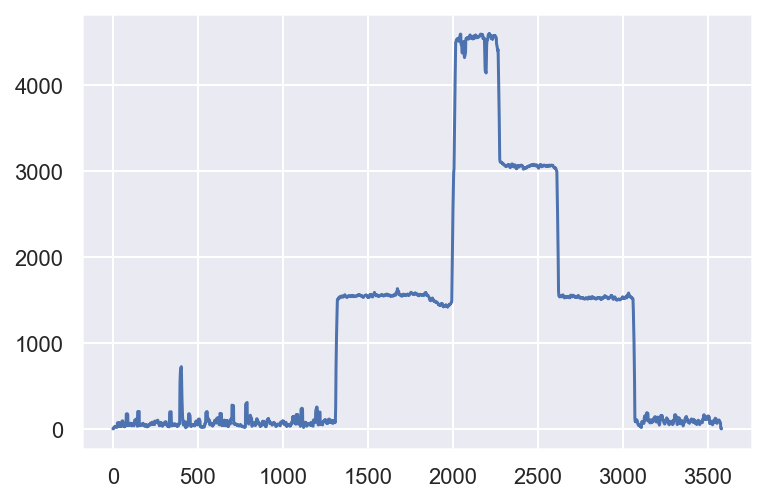

In [337]:
print(pred[:10])
print(pred[1500:1510])
plt.plot(values)

In [370]:
print(x["del"][0])
print(x["del"][1500])
print(x["del"][2500])
print(y["del"][1500])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[510, 562, 581, 507, 511, 516, 511, 516, 512, 512]
[999, 1002, 1004, 1001, 1010, 1051, 1046, 999, 997, 1004]
[22, 68, 96, 21, 20, 23, 26, 44, 36, 34]


In [371]:
values = x["del"]
clf = GaussianMixture(n_components = 2, random_state=0)
pred = clf.fit_predict(np.array(values))
# はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
normal, abnormal = Counter(pred).keys()
if Counter(pred[:9]).most_common()[0][0] == abnormal:
    normal, abnormal = abnormal, normal
loci = {i for i, p in enumerate(pred) if p == abnormal}


In [372]:
print(Counter(pred))
print(pred[:10])
print(pred[1500:1510])
print(pred[2500:2510])
print(loci)

Counter({0: 2397, 1: 1185})
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
{3257, 3258, 2853, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3502, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 3503, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 3504, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 3505, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 3506, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 2880, 2881, 3507, 2883, 2884, 2885, 3293, 2886, 2887, 2888, 2889, 2890, 2891, 215, 216, 217, 2892, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 3304, 3305, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 3306, 257, 258, 259, 260, 261, 262, 263, 264, 265, 3308, 3309, 3310, 3311, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 3312, 3313, 3314, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 3330, 3331, 2925, 3332, 2926, 3333, 388, 

In [374]:
print(x["del"][3257])
print(x["del"][1500])
print(x["del"][2500])
print(y["del"][1500])

[35, 86, 179, 104, 28, 49, 27, 92, 38, 68]
[510, 562, 581, 507, 511, 516, 511, 516, 512, 512]
[999, 1002, 1004, 1001, 1010, 1051, 1046, 999, 997, 1004]
[22, 68, 96, 21, 20, 23, 26, 44, 36, 34]


In [375]:
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(x["del"])
print(Counter(pred))
print(pred[:10])
print(pred[1500:1510])
print(pred[2500:2510])
print(loci)

Counter({1: 3018, -1: 564})
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[-1 -1 -1 -1 -1 -1 -1 -1  1  1]
{3257, 3258, 2853, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3502, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 3503, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 3504, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 3505, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 3506, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 2880, 2881, 3507, 2883, 2884, 2885, 3293, 2886, 2887, 2888, 2889, 2890, 2891, 215, 216, 217, 2892, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 3304, 3305, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 3306, 257, 258, 259, 260, 261, 262, 263, 264, 265, 3308, 3309, 3310, 3311, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 3312, 3313, 3314, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 3330, 3331, 2925, 3332, 2926, 3

In [382]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(np.array(y["del"]))
pred = clf.predict(x["del"])
print(Counter(pred))
print(pred[:10])
print(pred[1500:1510])
print(pred[2500:2510])

Counter({-1: 2373, 1: 1209})
[ 1  1  1  1  1  1  1  1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
True


In [387]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(np.array(indels_control["del"]).reshape(-1, 1))
pred = clf.predict(np.array(indels_sample["del"]).reshape(-1, 1))
print(Counter(pred))
print(pred[:10])
print(pred[1500:1510])
print(pred[2500:2510])

Counter({1: 2761, -1: 821})
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


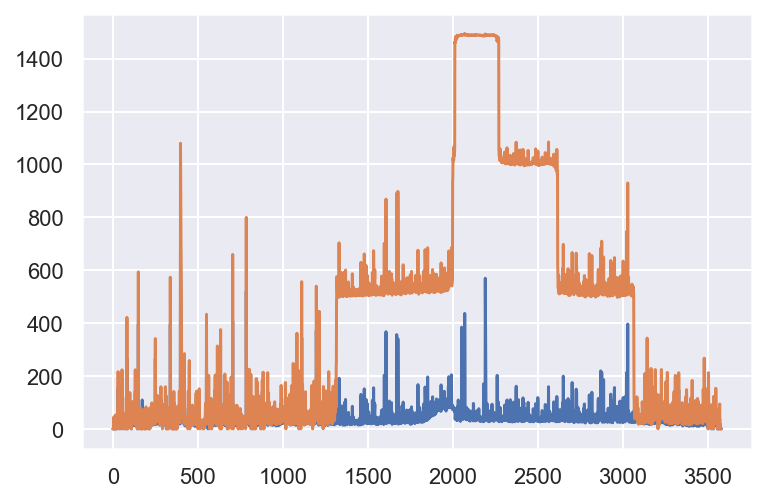

In [389]:
plt.plot(indels_control["del"])
plt.plot(indels_sample["del"])

In [390]:
def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in indels_sample.items():
        clf = GaussianMixture(n_components = 2, random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

In [391]:
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)

In [394]:
print(len(loci_sample["del"]))

618


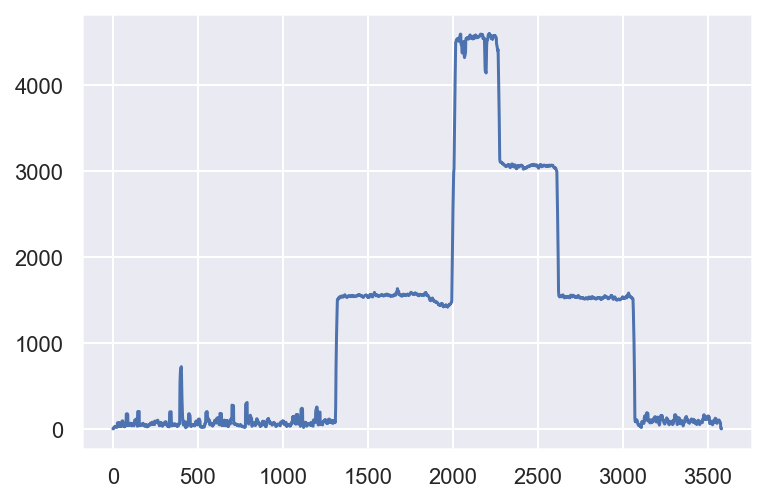

In [396]:
plt.plot(dists["del"])

In [398]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(np.array(y["del"]))
pred = clf.predict(x["del"])
print(Counter(pred))
print(pred[:10])
print(pred[1500:1510])
print(pred[2500:2510])

Counter({-1: 2373, 1: 1209})
[ 1  1  1  1  1  1  1  1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


- 試行錯誤のうちに、いまのところの結論は以下のとおりです
  - 安定して良い異常検知は見つかっていません
  - いまのところおそらく最善は「10kmerに分割したあとでLOFをかける」ことです

In [408]:
def _extract_anomaly_loci(indels_sample: dict, indels_control) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(np.array(indels_control[key]))
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    return _extract_anomaly_loci(x, y)


In [409]:
x = _extract(cssplits_sample, cssplits_control)

In [410]:
print(len(x["del"]))
print(50 in x["del"])
print(1500 in x["del"])
print(2500 in x["del"])
print(len(x["ins"]))
print(len(x["sub"]))


2373
False
True
True
764
447


- だいぶ補正がゆるくなったように感じますが、ここでいったん試します

In [414]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m36.869s
user	5m43.011s
sys	1m16.142s


- とりあえず3アレルになりました
    - inversionのところだけ謎なので確認して、本ノートは終わりにしようと思います
- 補正がゆるくなったので他のサンプルでは自信がないです

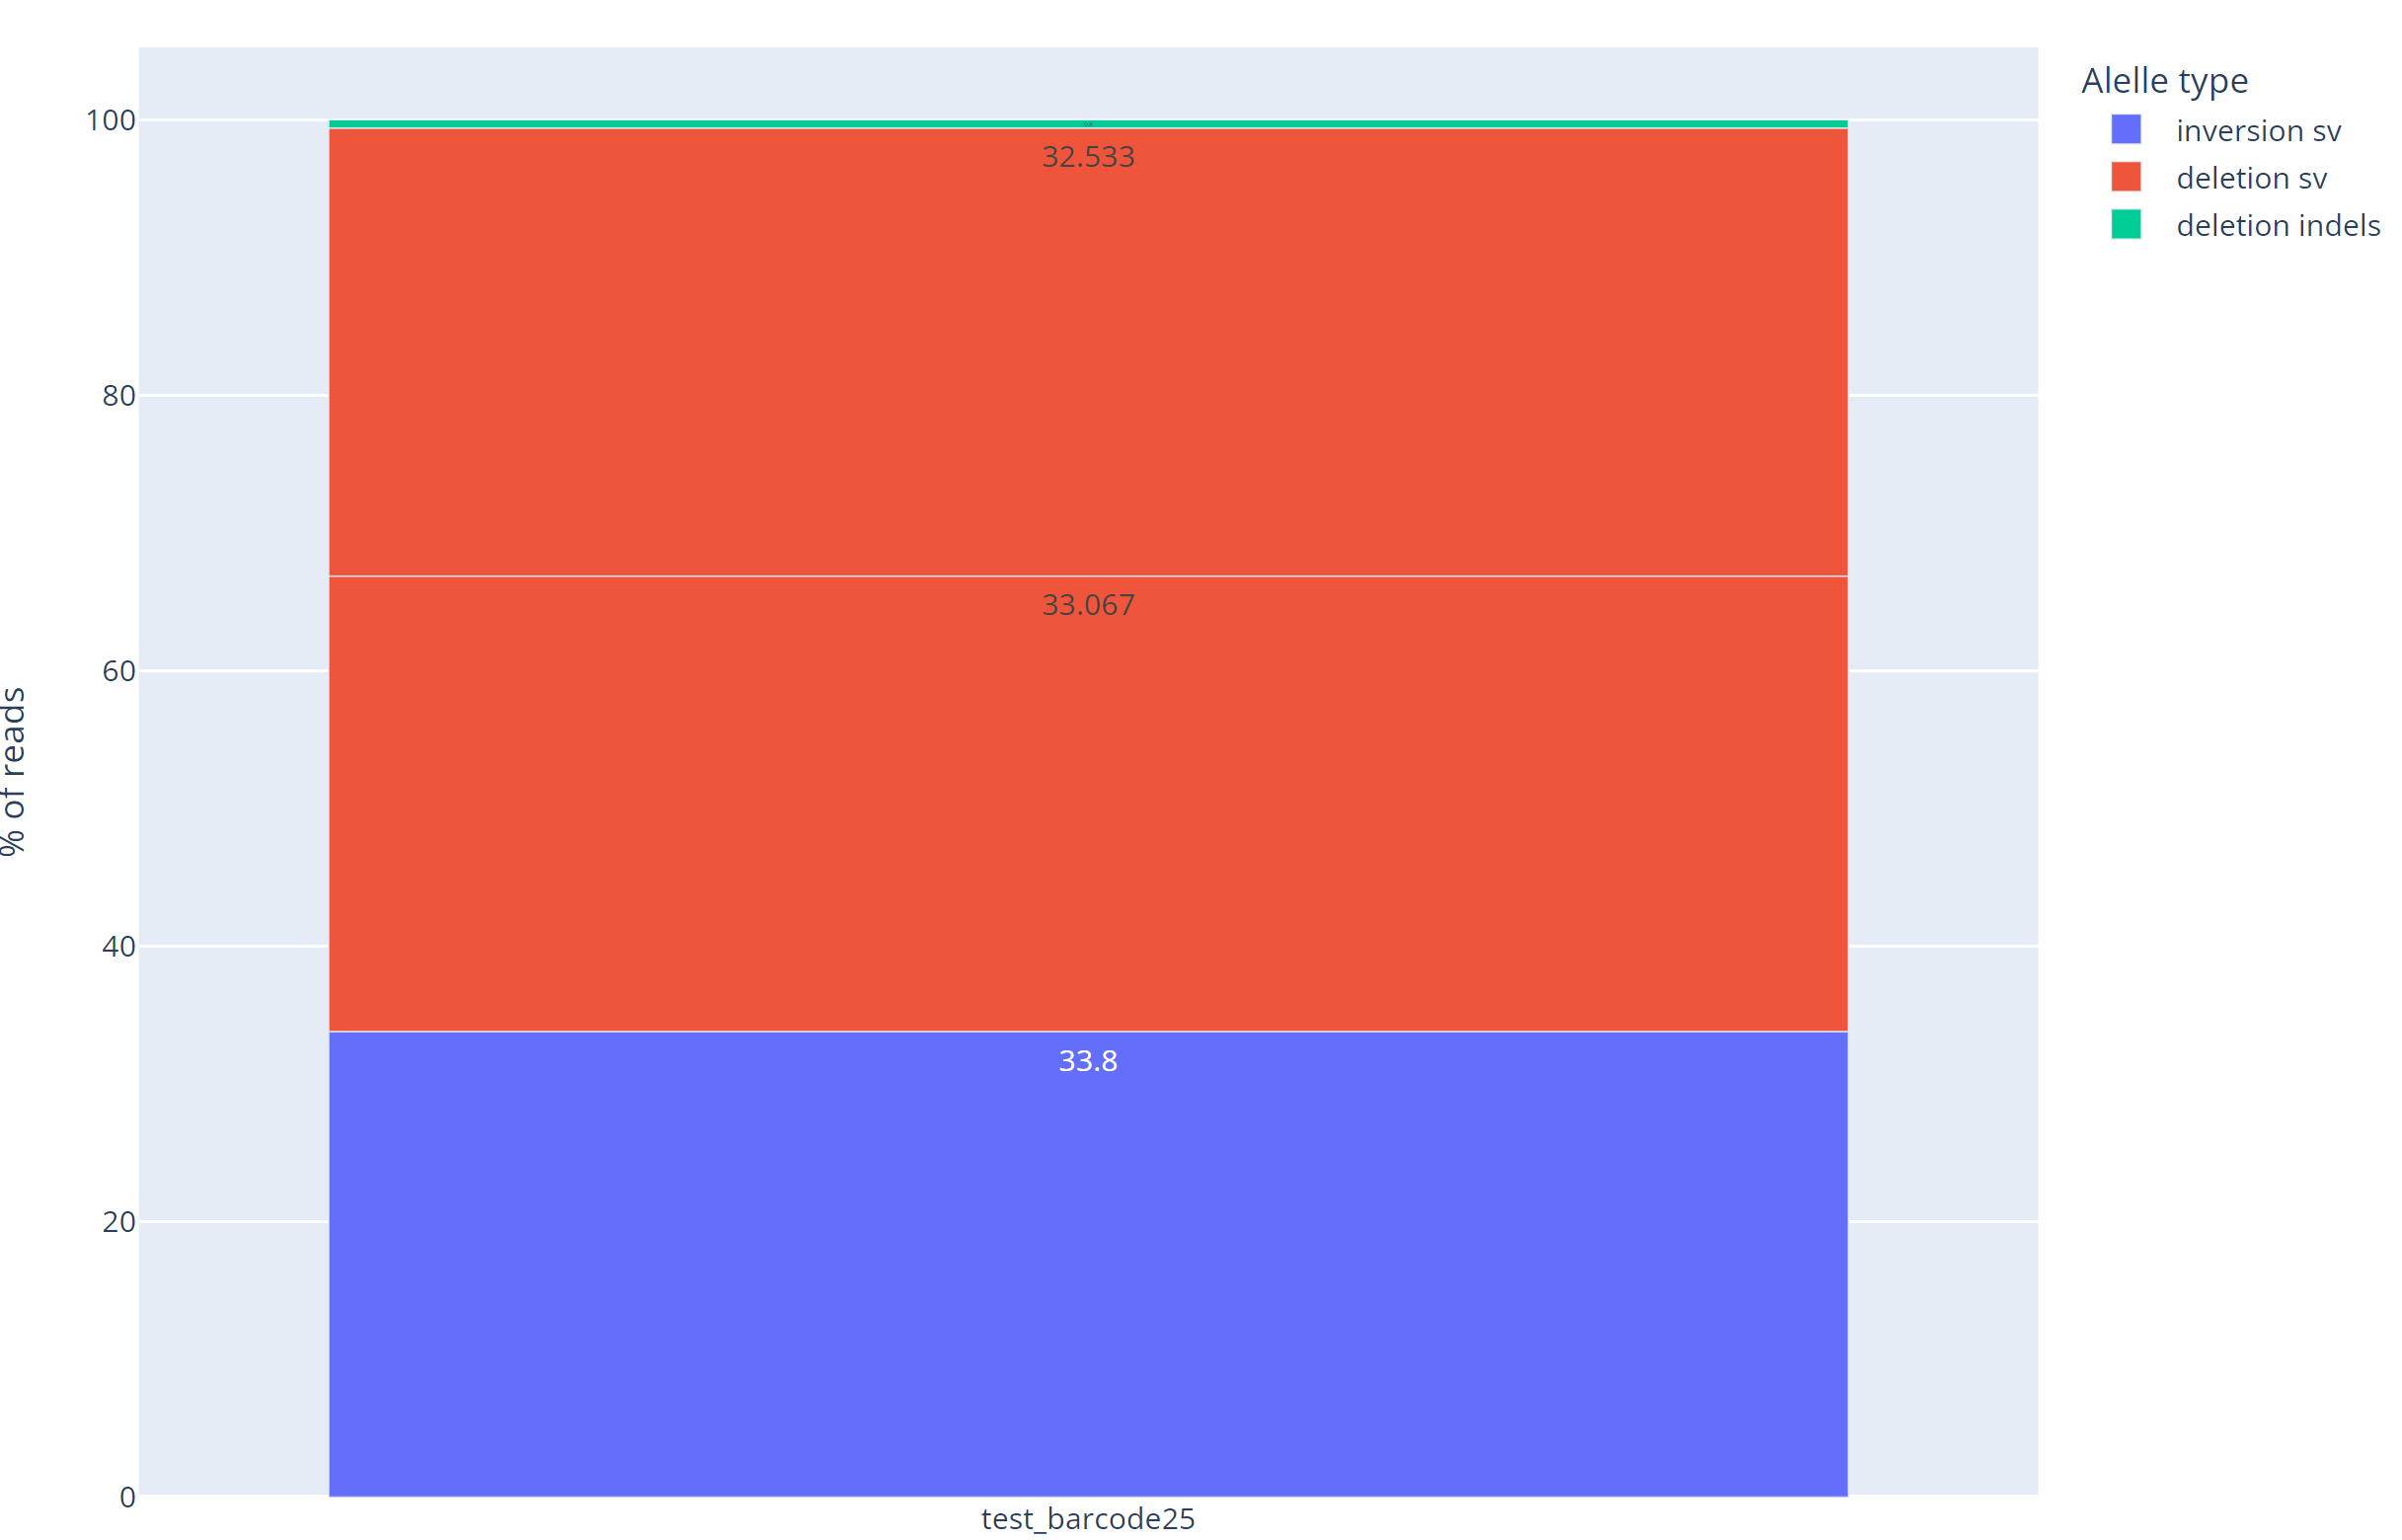

### inversionになっているリードを確認

In [415]:
results = midsv.read_jsonl("DAJINResults/.tempdir/single-stx2deletion-callmidsv/result/test_barcode25.jsonl")

In [418]:
for samp in results:
    if samp["ALLELE"] == "inversion":
        qname_inversion = samp["QNAME"]
        break

In [419]:
print(qname_inversion)

007d3e8d-6ba1-4be1-8169-8d6e94ddee0b


In [420]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby, permutations
from pathlib import Path

import midsv

from DAJIN2.core.preprocess import mappy_align


def _extract_diff_loci(TEMPDIR: Path) -> defaultdict[dict]:
    """
    Extract differencial loci between alleles
        - The purpose is to lower match_score between very similar alleles such as point mutation.
    """
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
    fasta_alleles = [f for f in fasta_alleles if f.suffix != ".fai"]
    mutation_alleles = defaultdict(dict)
    for pair in list(permutations(fasta_alleles, 2)):
        ref, query = pair
        ref_allele = ref.stem
        alignments = mappy_align.to_sam(ref, query, preset="splice")
        alignments = list(alignments)
        alignments = [a.split("\t") for a in alignments]
        alignments_midsv = midsv.transform(alignments, midsv=False, cssplit=True, qscore=False)[0]
        cssplits = alignments_midsv["CSSPLIT"].split(",")
        mutations = dict()
        for i, cs in enumerate(cssplits):
            if cs.startswith("="):
                continue
            mutations.update({i: cs})
        if len(mutations) < 10:
            mutation_alleles[ref_allele].update(mutations)
    return mutation_alleles


def _calc_match(CSSPLIT: str, mutations: dict) -> float:
    match_score = CSSPLIT.count("=")
    match_score -= CSSPLIT.count("+")  # insertion
    match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
    cssplit = CSSPLIT.split(",")
    for i, mut in mutations.items():
        if cssplit[i] == mut:
            match_score = 0
    return match_score / len(cssplit)


def classify_alleles(TEMPDIR: Path, SAMPLE_NAME: str) -> list[dict]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for path_midsv in paths_midsv:
        allele = path_midsv.stem.split("_")[-1]
        preset = path_midsv.stem.split("_")[-2]
        for dict_midsv in midsv.read_jsonl(path_midsv):
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            dict_midsv.update({"PRESET": preset})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    possible_allele = []
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        possible_allele.append(max_read)
    return possible_allele


In [421]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{SAMPLE_NAME}*.jsonl"))
mutations = _extract_diff_loci(TEMPDIR)
# Scoring
score_of_each_alleles = []
for path_midsv in paths_midsv:
    allele = path_midsv.stem.split("_")[-1]
    preset = path_midsv.stem.split("_")[-2]
    for dict_midsv in midsv.read_jsonl(path_midsv):
        score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
        dict_midsv.update({"SCORE": score})
        dict_midsv.update({"ALLELE": allele})
        dict_midsv.update({"PRESET": preset})
        score_of_each_alleles.append(dict_midsv)
score_of_each_alleles.sort(key=lambda x: x["QNAME"])


In [434]:
for score in score_of_each_alleles:
    if score["QNAME"] == qname_inversion:
        print(score["ALLELE"], score["CSSPLIT"].count("-"), score["SCORE"])

deletion 1642 0.5240089335566722
control 2316 0.4467393826873985
inversion 1308 0.6783476444650731


In [445]:
def call_midsv(TEMPDIR, SAMPLE_NAME, allele) -> None:
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
    sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
    qname_of_single_read = _get_qname_of_single_read(sam_ont)
    qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
    sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
    sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
    midsv_of_single_read = _midsv_transform(sam_of_map_ont)
    midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    midsv.write_jsonl(midsv_sample, f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")

for allele in FASTA_ALLELES:
    call_midsv(TEMPDIR, SAMPLE_NAME, allele)

preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [446]:
for allele in FASTA_ALLELES:
    midsv_inversion = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
    for samp in midsv_inversion:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), match_score)

deletion 0 0.4620323841429369
control 0 0.38407983290786724
inversion 0 0.38407983290786724


In [ ]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

# def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
#     anomaly_loci = dict()
#     for key, values in indels_sample.items():
#         clf = GaussianMixture(n_components = 2, random_state=0)
#         pred = clf.fit_predict(np.array(values).reshape(-1, 1))
#         # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
#         normal, abnormal = Counter(pred).keys()
#         if Counter(pred[:9]).most_common()[0][0] == abnormal:
#             normal, abnormal = abnormal, normal
#         loci = {i for i, p in enumerate(pred) if p == abnormal}
#         anomaly_loci.update({key: loci})
#     return anomaly_loci


# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci_hotelling(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    # mutation_locus_single = _extract_anomaly_loci(indels_sample)
    # mutation_locus_single = {}
    # loci_sample = _extract_anomaly_loci(indels_sample)
    # loci_control = _extract_anomaly_loci(indels_control)
    # for key in ["ins", "del", "sub"]:
    #     mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    return _extract_anomaly_loci(x, y)
    # dists = _calc_distance(x, y)
    # loci_sample = _extract_anomaly_loci(dists)
    # mutation_locus_kmer = {}
    # for key in ["ins", "del", "sub"]:
    #     # score_sample = _score_anomaly(dists[key])
    #     mutation_locus_kmer.update({key: loci_sample[key]})
    # # Output
    # mutation_loci = {}
    # for key in ["ins", "del", "sub"]:
    #     mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    # return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))

###############################################################################

# def _set_indexes(sequence: str):
#     sequence_length = len(sequence)
#     num_subset = sequence_length % 5
#     left_idx = 0
#     right_idx = sequence_length
#     if num_subset == 1:
#         left_idx += 1
#     elif num_subset == 2:
#         left_idx += 1
#         right_idx -= 1
#     elif num_subset == 3:
#         left_idx += 2
#         right_idx -= 1
#     elif num_subset == 4:
#         left_idx += 2
#         right_idx -= 2
#     return left_idx, right_idx


# def _count_5mer_indels(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
#     transposed = [list(t) for t in zip(*cssplits)]
#     count_5mer = []
#     for i in range(left_idx, right_idx, 5):
#         count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
#         cssplits_5mer = transposed[i : i + 5]
#         for j, cs in enumerate(cssplits_5mer):
#             counter = Counter(cs)
#             for key, cnt in counter.items():
#                 if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
#                     continue
#                 if key.startswith("+"):
#                     count["ins"][j] += cnt
#                 elif key.startswith("-"):
#                     count["del"][j] += cnt
#                 elif key.startswith("*"):
#                     count["sub"][j] += cnt
#         count_5mer.append(count)
#     return count_5mer


# def _remove_minor_indels(cssplits: list[list[str]], count_5mer: list[dict]) -> list[dict]:
#     coverage = len(cssplits)
#     count_5mer_filtered = []
#     for count in count_5mer:
#         dict_mutation = defaultdict(list)
#         for mutation in ["ins", "del", "sub"]:
#             if all(True if c < coverage * 0.01 else False for c in count[mutation]):
#                 dict_mutation[mutation] = [1] * 5
#             else:
#                 dict_mutation[mutation] = count[mutation]
#         count_5mer_filtered.append(dict_mutation)
#     return count_5mer_filtered


# def _extract_sequence_errors(count_5mer_sample, count_5mer_control):
#     sequence_errors = [set() for _ in range(len(count_5mer_sample))]
#     dists = defaultdict(list)
#     # Calculate Jensen-Shannon distance
#     for samp, cont in zip(count_5mer_sample, count_5mer_control):
#         for mutation in ["ins", "del", "sub"]:
#             s = samp[mutation]
#             c = cont[mutation]
#             dists[mutation].append(distance.jensenshannon(s, c))
#     # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
#     dists_all = np.array(list(dists.values())).flatten()
#     avg = np.average(dists_all[~np.isnan(dists_all)])
#     var = np.var(dists_all[~np.isnan(dists_all)])
#     threshold = 0.05
#     for mutation in ["ins", "del", "sub"]:
#         dists_subset = dists[mutation]
#         scores = [(xi - avg) ** 2 / var for xi in dists_subset]
#         thres = stats.chi2.interval(1 - threshold, 1)[1]
#         for i, score in enumerate(scores):
#             # 'nan' means the two distributions have too different, so it could be a real mutation
#             if np.isnan(score):
#                 continue
#             if score < thres:
#                 sequence_errors[i].add(mutation)
#     return sequence_errors


# def _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
#     cssplits_replaced = []
#     for samp in cssplits_sample:
#         samp_replaced = samp.copy()
#         for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
#             samp_5mer = samp[idx_5mer : idx_5mer + 5]
#             error = sequence_errors[idx_error]
#             if "ins" in error:
#                 samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
#             if "del" in error:
#                 samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
#             if "sub" in error:
#                 samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
#             samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
#         cssplits_replaced.append(samp_replaced)
#     return cssplits_replaced


# def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
#     random.seed(1)
#     cssplits_replaced = cssplits.copy()
#     sequence_length = len(sequence)
#     for i in range(1, sequence_length - 1):
#         cssplits_atmark = defaultdict(str)
#         cssplits_sampling_key = defaultdict(list)
#         cssplits_sampling_all = []
#         flag_all_atmark = True
#         for idx, cssplit in enumerate(cssplits):
#             key = ",".join([cssplit[i - 1], cssplit[i + 1]])
#             if cssplit[i] == "@":
#                 cssplits_atmark[idx] = key
#             else:
#                 cssplits_sampling_key[key].append(cssplit[i])
#                 cssplits_sampling_all.append(cssplit[i])
#                 flag_all_atmark = False
#         for idx, key in cssplits_atmark.items():
#             if flag_all_atmark:
#                 cssplits_replaced[idx][i] = "N"
#             elif cssplits_sampling_key[key]:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
#             else:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
#     for cs in cssplits_replaced:
#         if cs[0] == "@":
#             cs[0] = "N"
#         if cs[-1] == "@":
#             cs[-1] = "N"
#     return cssplits_replaced


# ###############################################################################
# # main
# ###############################################################################


# def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
#     for allele, sequence in FASTA_ALLELES.items():
#         midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
#         midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
#         cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
#         cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
#         # Extract sequence errors
#         left_idx, right_idx = _set_indexes(sequence)
#         count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
#         count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
#         count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
#         count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
#         sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
#         # Correct sequence errors
#         cssplits_sample_error_replaced = _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
#         cssplits_control_error_replaced = _replace_errors_to_atmark(
#             cssplits_control, sequence_errors, left_idx, right_idx
#         )
#         cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_error_replaced, sequence)
#         cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_error_replaced, sequence)
#         # Replace CSSPLIT
#         cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
#         cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
#         for i, cssplits in enumerate(cssplits_sample_corrected):
#             midsv_sample[i]["CSSPLIT"] = cssplits
#         for i, cssplits in enumerate(cssplits_control_corrected):
#             midsv_control[i]["CSSPLIT"] = cssplits
#         midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
#         midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [447]:
# correct_sequence_errorをします
execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [448]:
for allele in FASTA_ALLELES:
    midsv_inversion = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
    for samp in midsv_inversion:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), match_score)

deletion 70 0.9550530429927415
control 520 0.8521698770016245
inversion 456 0.8463680668368531


In [449]:
preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [450]:
for allele in FASTA_ALLELES:
    midsv_inversion = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
    for samp in midsv_inversion:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+") # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), match_score)

deletion 70 0.9558905639307649
control 520 0.8551868182873057
inversion 456 0.8628452077048039


In [451]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

In [452]:
for samp in classif_sample:
    if samp["QNAME"] == qname_inversion:
        print(samp)

{'QNAME': '007d3e8d-6ba1-4be1-8169-8d6e94ddee0b', 'RNAME': 'deletion', 'CSSPLIT': '=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,*AG,*GA,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,*TG,=T,=G,=A,=T,=G,=G,*AG,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=

- `qname_inversion`がinversionにならず、問題が再現できないのですが…？
- あと、`preprocess.correct_knockin`が時間かかりすぎです（4分くらいかかっています）

- 再現できないので、もう一度実行します。

In [453]:
%%bash
rm -rf DAJINResults/single-stx2deletion-callmidsv
rm -rf DAJINResults/.tempdir/single-stx2deletion-callmidsv

time DAJIN2 \
    --name single-stx2deletion-callmidsv \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-callmidsv to see the report.

real	5m39.587s
user	5m34.902s
sys	1m1.298s


- とりあえずinversionの問題は再現されました
- 次回はまずinversionの問題を取り上げます。
    - 次に補正が弱い領域（ホモポリマー領域）を補正します
    - そしてTyrやAyabe-Taskを行います


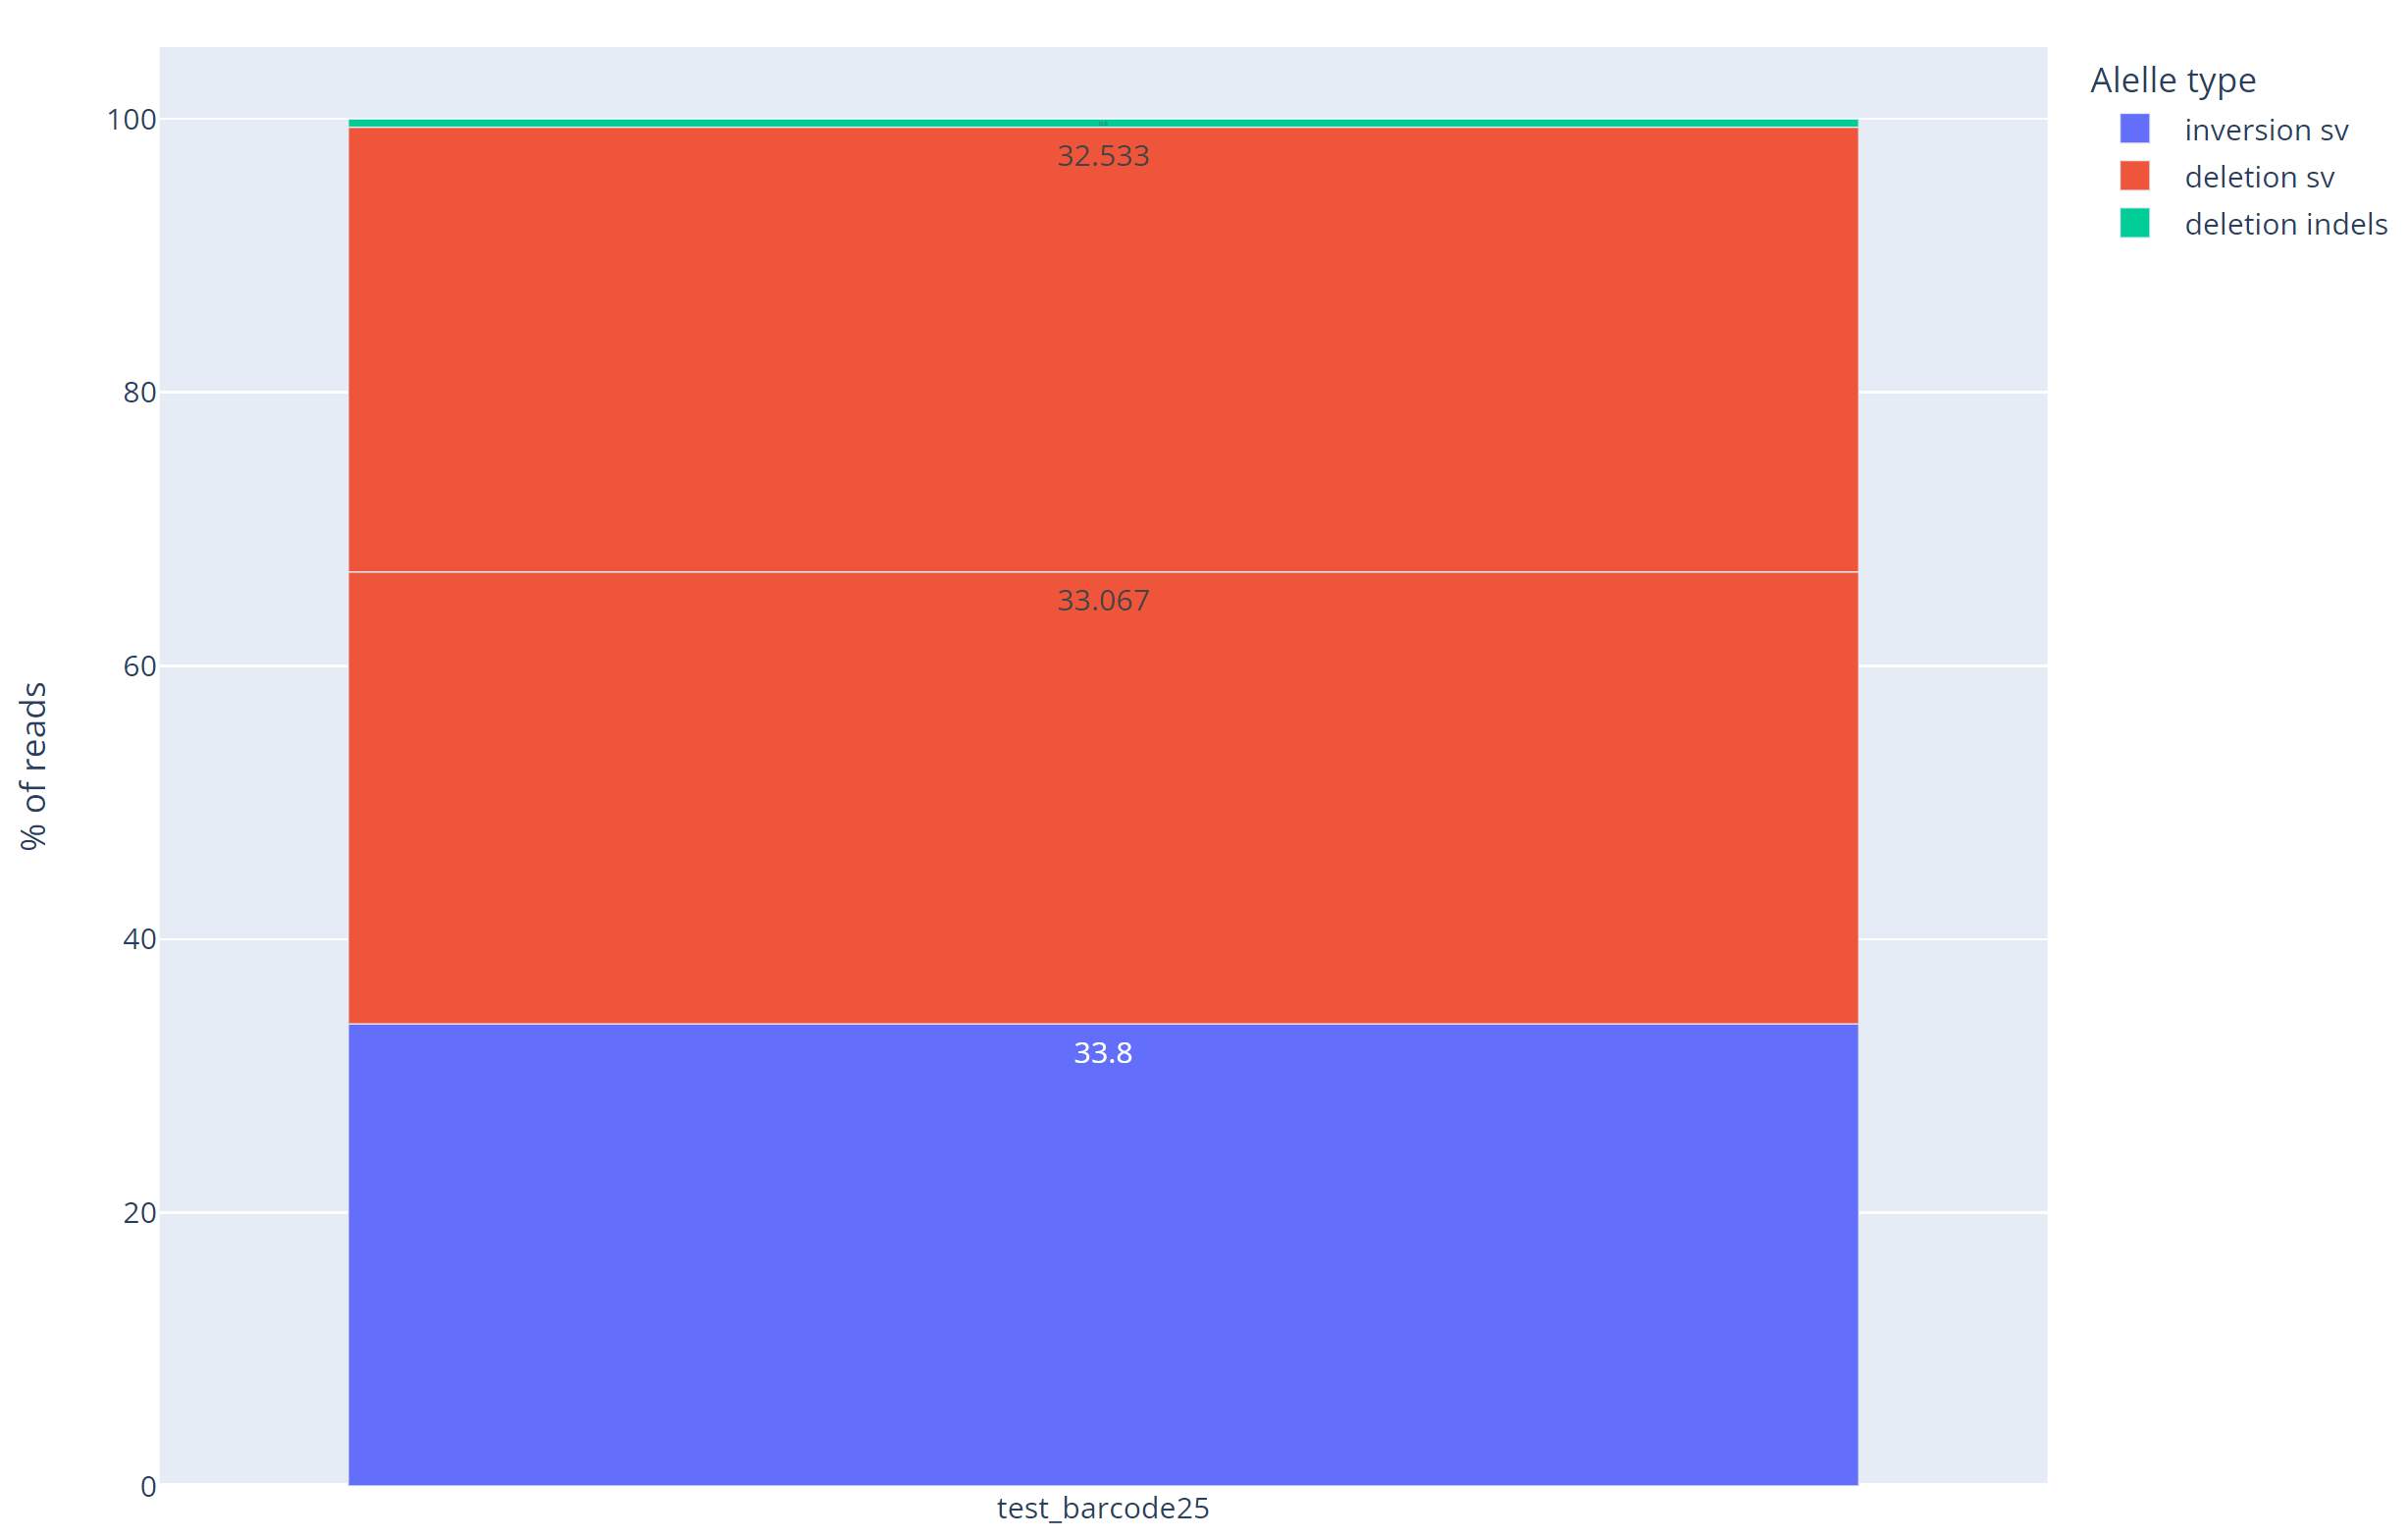

In [454]:
for allele in FASTA_ALLELES:
    midsv_sample = midsv.read_jsonl(f"{TEMPDIR}/midsv/{SAMPLE_NAME}_{allele}.jsonl")
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)

deletion 0 1642 0.5240089335566722
control 0 2316 0.4467393826873985
inversion 2 1308 0.6783476444650731


In [464]:
# 一旦リセット…
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)


def _replaceNtoD(cssplits_sample, sequence) -> list[list[str]]:
    cssplits_replaced = cssplits_sample.copy()
    for i, cssplits in enumerate(cssplits_sample):
        # extract right/left index of the end of sequential Ns
        left_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            left_idx_n += 1
        right_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            right_idx_n += 1
        right_idx_n = len(cssplits) - right_idx_n - 1
        # replace sequential Ns within the sequence
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if left_idx_n <= j <= right_idx_n and cs == "N":
                cssplits_replaced[i][j] = f"-{seq}"
    return cssplits_replaced

from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci

# def _extract_anomaly_loci(indels_sample: dict) -> dict[str, set[int]]:
#     anomaly_loci = dict()
#     for key, values in indels_sample.items():
#         clf = GaussianMixture(n_components = 2, random_state=0)
#         pred = clf.fit_predict(np.array(values).reshape(-1, 1))
#         # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
#         normal, abnormal = Counter(pred).keys()
#         if Counter(pred[:9]).most_common()[0][0] == abnormal:
#             normal, abnormal = abnormal, normal
#         loci = {i for i, p in enumerate(pred) if p == abnormal}
#         anomaly_loci.update({key: loci})
#     return anomaly_loci


# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci_hotelling(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    # mutation_locus_single = _extract_anomaly_loci(indels_sample)
    # mutation_locus_single = {}
    # loci_sample = _extract_anomaly_loci(indels_sample)
    # loci_control = _extract_anomaly_loci(indels_control)
    # for key in ["ins", "del", "sub"]:
    #     mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    return _extract_anomaly_loci(x, y)
    # dists = _calc_distance(x, y)
    # loci_sample = _extract_anomaly_loci(dists)
    # mutation_locus_kmer = {}
    # for key in ["ins", "del", "sub"]:
    #     # score_sample = _score_anomaly(dists[key])
    #     mutation_locus_kmer.update({key: loci_sample[key]})
    # # Output
    # mutation_loci = {}
    # for key in ["ins", "del", "sub"]:
    #     mutation_loci.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    # return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))

###############################################################################

# def _set_indexes(sequence: str):
#     sequence_length = len(sequence)
#     num_subset = sequence_length % 5
#     left_idx = 0
#     right_idx = sequence_length
#     if num_subset == 1:
#         left_idx += 1
#     elif num_subset == 2:
#         left_idx += 1
#         right_idx -= 1
#     elif num_subset == 3:
#         left_idx += 2
#         right_idx -= 1
#     elif num_subset == 4:
#         left_idx += 2
#         right_idx -= 2
#     return left_idx, right_idx


# def _count_5mer_indels(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
#     transposed = [list(t) for t in zip(*cssplits)]
#     count_5mer = []
#     for i in range(left_idx, right_idx, 5):
#         count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
#         cssplits_5mer = transposed[i : i + 5]
#         for j, cs in enumerate(cssplits_5mer):
#             counter = Counter(cs)
#             for key, cnt in counter.items():
#                 if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
#                     continue
#                 if key.startswith("+"):
#                     count["ins"][j] += cnt
#                 elif key.startswith("-"):
#                     count["del"][j] += cnt
#                 elif key.startswith("*"):
#                     count["sub"][j] += cnt
#         count_5mer.append(count)
#     return count_5mer


# def _remove_minor_indels(cssplits: list[list[str]], count_5mer: list[dict]) -> list[dict]:
#     coverage = len(cssplits)
#     count_5mer_filtered = []
#     for count in count_5mer:
#         dict_mutation = defaultdict(list)
#         for mutation in ["ins", "del", "sub"]:
#             if all(True if c < coverage * 0.01 else False for c in count[mutation]):
#                 dict_mutation[mutation] = [1] * 5
#             else:
#                 dict_mutation[mutation] = count[mutation]
#         count_5mer_filtered.append(dict_mutation)
#     return count_5mer_filtered


# def _extract_sequence_errors(count_5mer_sample, count_5mer_control):
#     sequence_errors = [set() for _ in range(len(count_5mer_sample))]
#     dists = defaultdict(list)
#     # Calculate Jensen-Shannon distance
#     for samp, cont in zip(count_5mer_sample, count_5mer_control):
#         for mutation in ["ins", "del", "sub"]:
#             s = samp[mutation]
#             c = cont[mutation]
#             dists[mutation].append(distance.jensenshannon(s, c))
#     # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
#     dists_all = np.array(list(dists.values())).flatten()
#     avg = np.average(dists_all[~np.isnan(dists_all)])
#     var = np.var(dists_all[~np.isnan(dists_all)])
#     threshold = 0.05
#     for mutation in ["ins", "del", "sub"]:
#         dists_subset = dists[mutation]
#         scores = [(xi - avg) ** 2 / var for xi in dists_subset]
#         thres = stats.chi2.interval(1 - threshold, 1)[1]
#         for i, score in enumerate(scores):
#             # 'nan' means the two distributions have too different, so it could be a real mutation
#             if np.isnan(score):
#                 continue
#             if score < thres:
#                 sequence_errors[i].add(mutation)
#     return sequence_errors


# def _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
#     cssplits_replaced = []
#     for samp in cssplits_sample:
#         samp_replaced = samp.copy()
#         for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
#             samp_5mer = samp[idx_5mer : idx_5mer + 5]
#             error = sequence_errors[idx_error]
#             if "ins" in error:
#                 samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
#             if "del" in error:
#                 samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
#             if "sub" in error:
#                 samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
#             samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
#         cssplits_replaced.append(samp_replaced)
#     return cssplits_replaced


# def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
#     random.seed(1)
#     cssplits_replaced = cssplits.copy()
#     sequence_length = len(sequence)
#     for i in range(1, sequence_length - 1):
#         cssplits_atmark = defaultdict(str)
#         cssplits_sampling_key = defaultdict(list)
#         cssplits_sampling_all = []
#         flag_all_atmark = True
#         for idx, cssplit in enumerate(cssplits):
#             key = ",".join([cssplit[i - 1], cssplit[i + 1]])
#             if cssplit[i] == "@":
#                 cssplits_atmark[idx] = key
#             else:
#                 cssplits_sampling_key[key].append(cssplit[i])
#                 cssplits_sampling_all.append(cssplit[i])
#                 flag_all_atmark = False
#         for idx, key in cssplits_atmark.items():
#             if flag_all_atmark:
#                 cssplits_replaced[idx][i] = "N"
#             elif cssplits_sampling_key[key]:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
#             else:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
#     for cs in cssplits_replaced:
#         if cs[0] == "@":
#             cs[0] = "N"
#         if cs[-1] == "@":
#             cs[-1] = "N"
#     return cssplits_replaced


# ###############################################################################
# # main
# ###############################################################################


# def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
#     for allele, sequence in FASTA_ALLELES.items():
#         midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
#         midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
#         cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
#         cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
#         # Extract sequence errors
#         left_idx, right_idx = _set_indexes(sequence)
#         count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
#         count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
#         count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
#         count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
#         sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
#         # Correct sequence errors
#         cssplits_sample_error_replaced = _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
#         cssplits_control_error_replaced = _replace_errors_to_atmark(
#             cssplits_control, sequence_errors, left_idx, right_idx
#         )
#         cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_error_replaced, sequence)
#         cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_error_replaced, sequence)
#         # Replace CSSPLIT
#         cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
#         cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
#         for i, cssplits in enumerate(cssplits_sample_corrected):
#             midsv_sample[i]["CSSPLIT"] = cssplits
#         for i, cssplits in enumerate(cssplits_control_corrected):
#             midsv_control[i]["CSSPLIT"] = cssplits
#         midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
#         midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [465]:
for allele in FASTA_ALLELES:
    sam_ont = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam")
    sam_splice = midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam")
    qname_of_single_read = _get_qname_of_single_read(sam_ont)
    qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice, qname_of_single_read)
    sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
    sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
    midsv_of_single_read = _midsv_transform(sam_of_map_ont)
    midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
    midsv_sample = midsv_of_single_read + midsv_of_multiple_reads
    print("Initial Score =================")
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)
    print("REPLACE N to D =================")
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
    cssplits_replaced = _replaceNtoD(cssplits_sample, sequence)
    midsv_cssplits = [",".join(cs) for cs in cssplits_replaced]
    for i, cssplits in enumerate(midsv_cssplits):
        midsv_sample[i]["CSSPLIT"] = cssplits
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)
    print("CORRECT SEQUENCE ERROR =================")
    midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
    cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    # Extract mutation loci
    mutation_loci = _extract(cssplits_sample, cssplits_control)
    # Correct sequence errors
    cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
    cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
    cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
    cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
    # Replace CSSPLIT
    cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
    cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
    for i, cssplits in enumerate(cssplits_sample_corrected):
        midsv_sample[i]["CSSPLIT"] = cssplits
    for i, cssplits in enumerate(cssplits_control_corrected):
        midsv_control[i]["CSSPLIT"] = cssplits
    for samp in midsv_sample:
        if samp["QNAME"] == qname_inversion:
            CSSPLIT = samp["CSSPLIT"]
            match_score = CSSPLIT.count("=")
            match_score -= CSSPLIT.count("+")  # insertion
            match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
            match_score /= len(CSSPLIT.split(","))
            print(allele, samp["CSSPLIT"].count("N"), samp["CSSPLIT"].count("-"),match_score)


Initial Score =================
deletion 1749 60 0.4620323841429369
REPLACE N to D =================
deletion 0 1809 0.4620323841429369
CORRECT SEQUENCE ERROR =================
deletion 0 1783 0.48464544946957006
Initial Score =================
control 2476 60 0.38407983290786724
REPLACE N to D =================
control 210 2326 0.38407983290786724
CORRECT SEQUENCE ERROR =================
control 210 2300 0.39684381527036433
Initial Score =================
inversion 2476 60 0.38407983290786724
REPLACE N to D =================
inversion 210 2326 0.38407983290786724
CORRECT SEQUENCE ERROR =================
inversion 211 1419 0.5996750986307728


- inversionのアレルがなぜかめちゃくちゃ補正されている！
- `midsv.transform`で`splice`のときの挿入と欠失が直に反映されてしまっている（inversionとして小文字になっていない…）

In [479]:
allele = "inversion"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))

In [478]:
count = defaultdict(int)
for cont in midsv_control:
    count[cont["CSSPLIT"].split(",")[2500]] += 1

print(count)
print(cont["CSSPLIT"])

defaultdict(<class 'int'>, {'-C': 881, 'N': 104, '=C': 2, '=c': 20, '-c': 1})
=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,+G|+A|=G,=A,=A,=G,+A|*GA,*CA,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,*GA,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,-C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,+A|+A|+A|*GA,=C,-T,=T,=A,=G,+C|=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,+C|=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,-A,=G,=G,=G,=G,=T,=A,=G,+C|=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,+G|+A|=G,=A,=G,=G,=T,+A|+A|+G|=G,=A,=G,=T,=G,=A,=G,=T,+C|=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,*GA,=C,=C,*GA,=C,+T|+T|+T|+T|=A,=T,=A,+C|=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=

In [480]:
count = defaultdict(int)
for cont in midsv_sample:
    count[cont["CSSPLIT"].split(",")[2500]] += 1

print(count)
print(cont["CSSPLIT"])

defaultdict(<class 'int'>, {'-C': 1495, 'N': 2, '=C': 3})
=G,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,-C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,*CT,*AT,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,+T|=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=

In [482]:
preset = "splice"
sam_control = midsv.read_sam((Path(TEMPDIR, "sam", f"{CONTROL_NAME}_{preset}_{allele}.sam")))

In [486]:
def split_cigar(CIGAR: str) -> list[str]:
    cigar = re.split(r"([MDINSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    return cigar_split

def has_inversion_in_splice(CIGAR: str) -> bool:
    is_splice = False
    is_insertion = False
    for cigar in split_cigar(CIGAR):
        if cigar.endswith("I"):
            is_insertion = True
            continue
        if is_insertion and cigar.endswith("N"):
            is_splice = True
            break
        else:
            is_insertion = False
    return is_splice
print(has_splice(sam_control[100][5]))

True


In [492]:
cigars = "1I1N"
print(has_splice(cigars))

cigars = "11N"
print(has_splice(cigars))

cigars = "1I100D1N"
print(has_splice(cigars))


True
False
False


- `_extract_qname_of_map_ont`において

In [493]:
%%bash
rm -rf DAJINResults/single-stx2deletion-extract_qname_of_map_ont
rm -rf DAJINResults/.tempdir/single-stx2deletion-extract_qname_of_map_ont

time DAJIN2 \
    --name single-stx2deletion-extract_qname_of_map_ont \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-extract_qname_of_map_ont to see the report.

real	1m55.604s
user	2m16.426s
sys	1m48.394s


- まだinversionがあります…
- そろそろ膨大になりすぎたので、次のノートブックにします
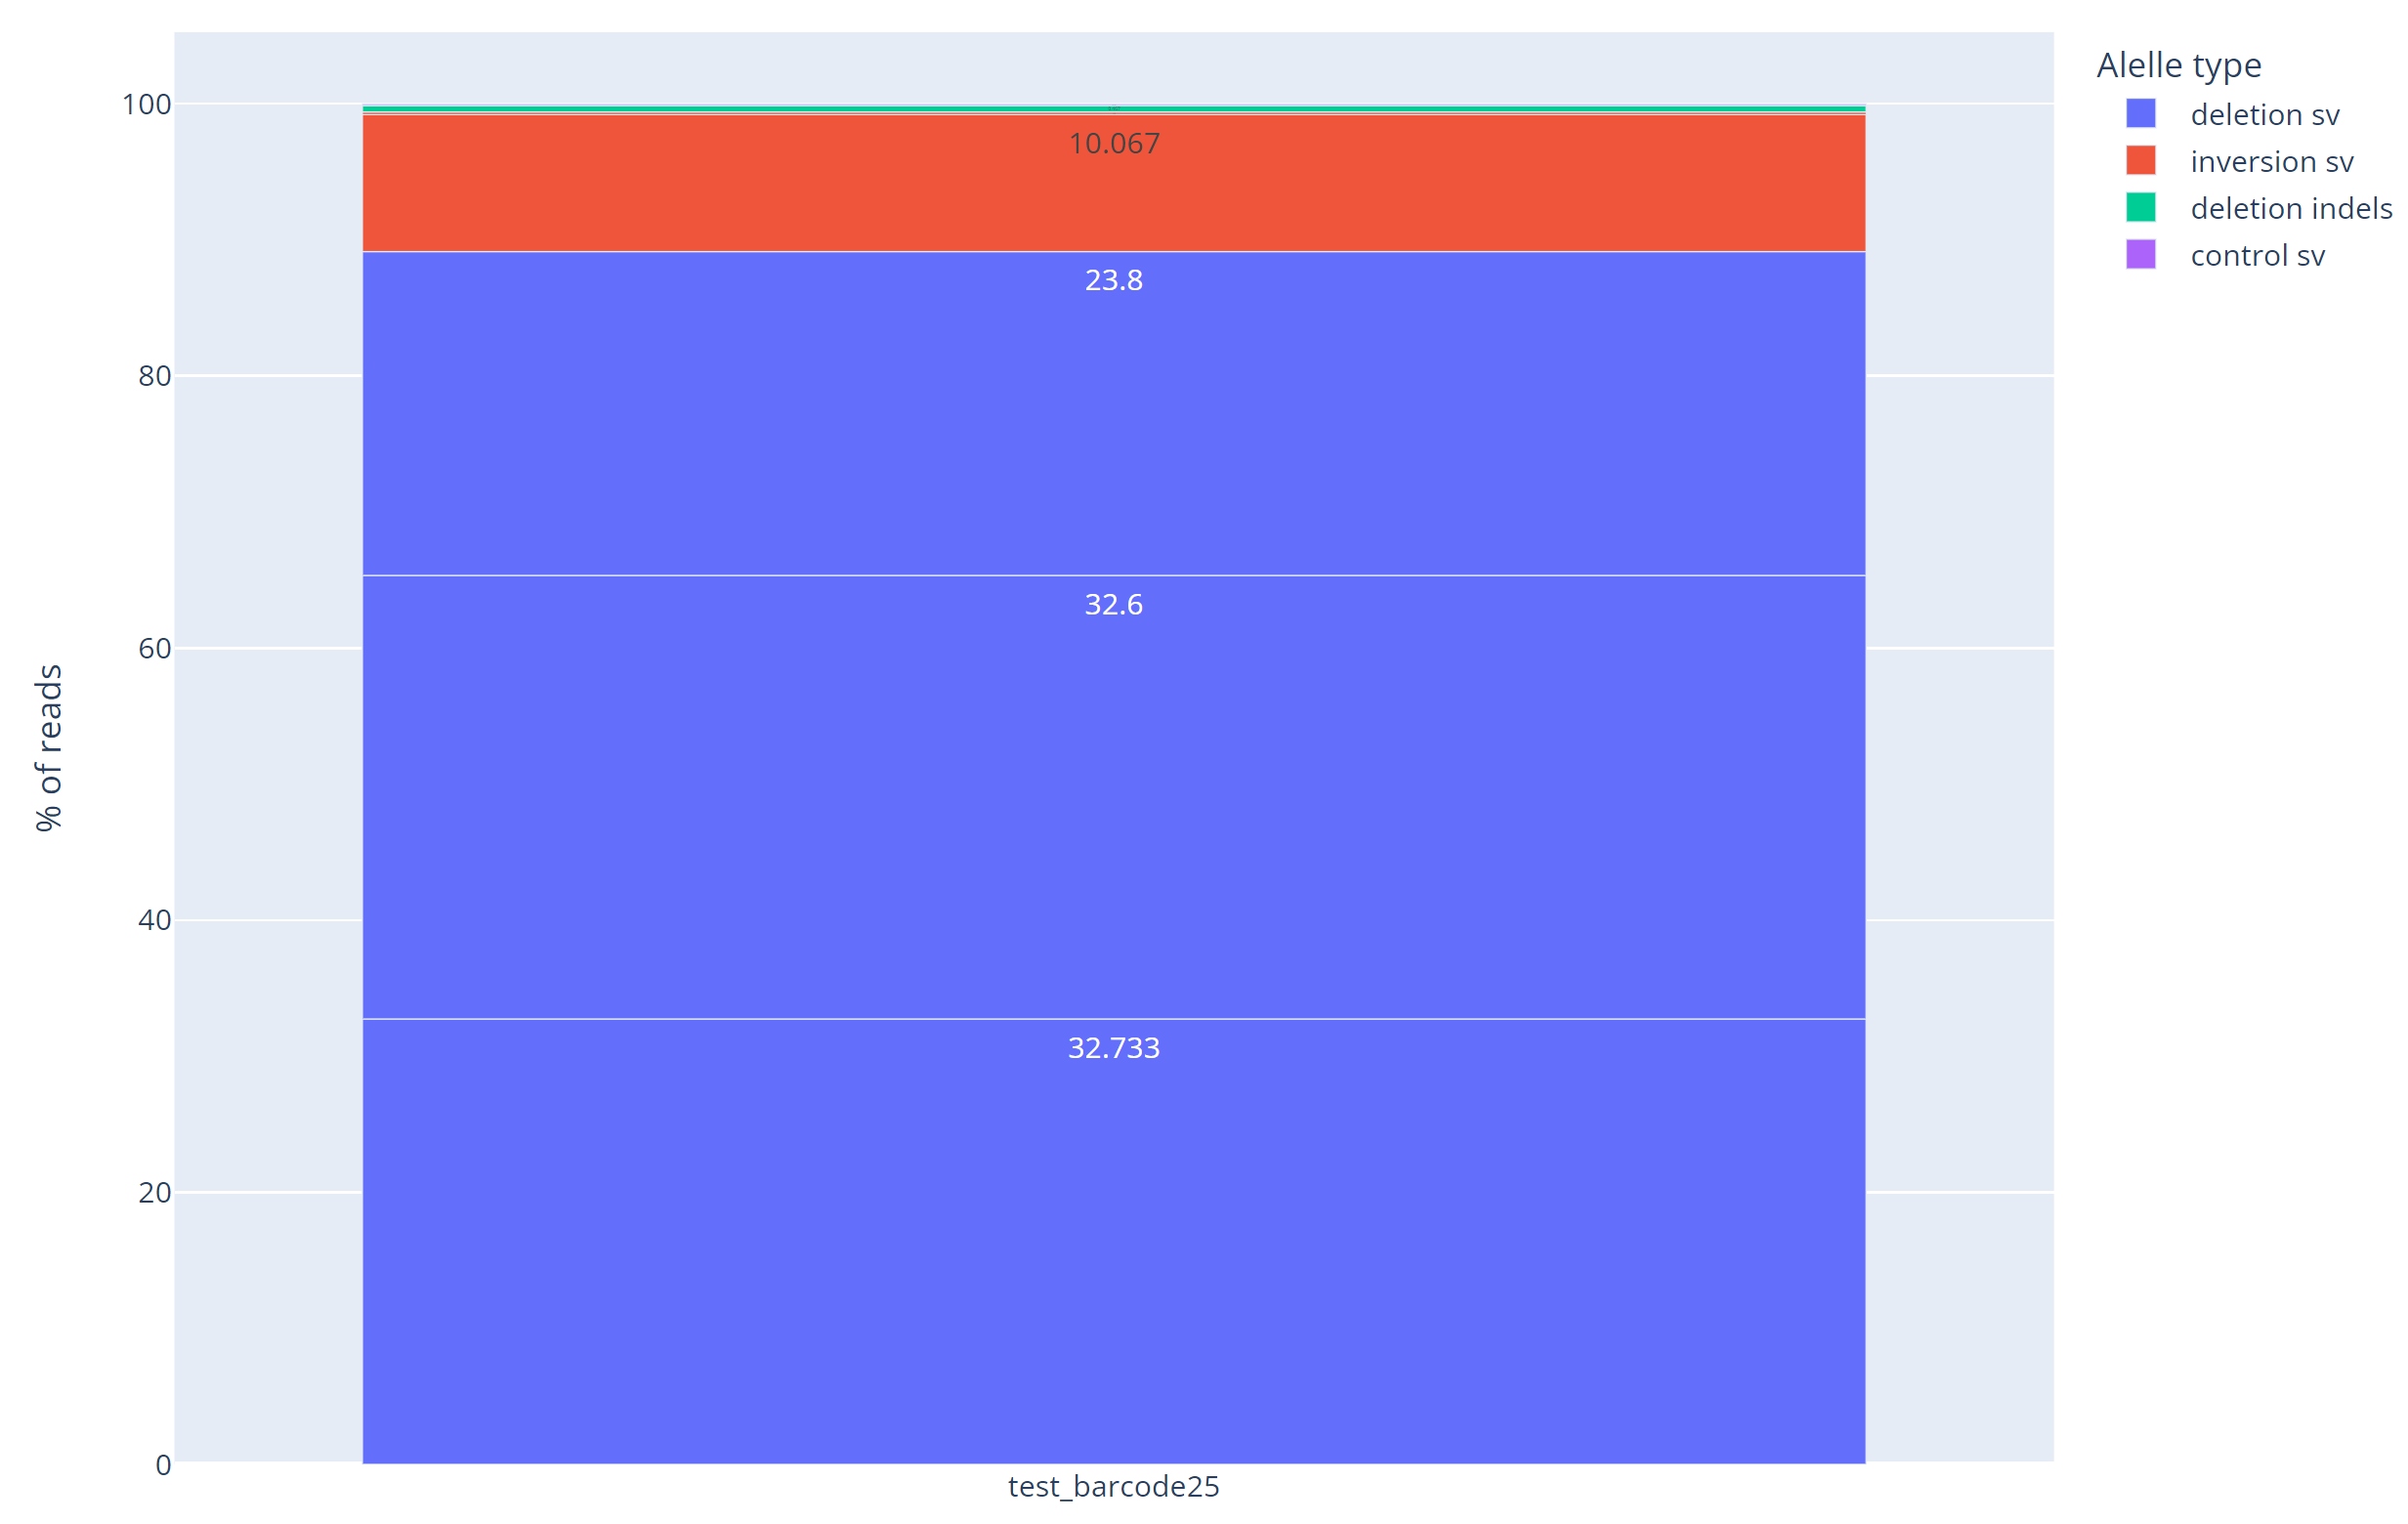

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- 長くなってきたので一旦ここでまとめます

- `correct_sequence_error`を改善？したのちにTyrやStx2で試したのですが、いまいちでした
- 調べてみると、`map-ont`と`splice`でアラインメント結果が異なることが原因でした
    - いまの`correct_sequence_error`ではアラインメント情報を以前よりも正しく捉えられているようでした
    - なのでアルゴリズムは継続しようと思っています
- `map-ont`と`splice`の違いを考慮するために、それぞれの強みを生かして超大型欠失がない場合（単一のアラインメント）のときには`map-ont`、それ以外には`splice`を使うという形にしました
    - そうするとなぜかStx2の分類結果がめちゃくちゃになりました
    - とくに`control`が出てくるのが謎すぎるので、次回検討します

# 次に取り組むこと

- 現状のアルゴリズムの動作確認をTyr, Stx2, Floxで行う
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする